# Automated News Update, or, "Dwyer's attempt at automating himself out of a job"

### To Do
* Fix Detroit News
* Functionality to add news article to SQL database after the fact
* Add Phys.org
* Add infinite scrolling functionality to css_scraypuh

### Can't because of paywalls:
* WSJ
* Nikkei
* Automotive World

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import packages, define important stuff

## Import packages

In [3]:
import os
import sys

import numpy as np
import pandas as pd
import datetime as dt
import time

import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from bs4 import BeautifulSoup, SoupStrainer
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
import requests

import docx
from docx.enum.text import WD_COLOR_INDEX
from docx.shared import Pt
from docx.shared import Inches

import random

#!pip install nltk
import nltk
#nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

import multiprocessing

## Global variables and dictionary of scrapers

In [4]:
# Search date and search date string for file naming and tracking
search_date = dt.date.today()
search_date_str = str(search_date)

# Essential keys to include in scraper_info subdictionaries:
# 'day': Integer that represents the day of the week that corresponds with a particular scraper. e.g., 0==Monday.
# 'keywords': Keyword lists for each of the different news updates
# 'bad_words': If any of these words are in the article title, drop article. Words are not case sensitive.
# 'ideal_no_articles': Ideal number of articles to be scraped for each scraper.  If excess articles are scraped, the articles will be sampled (articles from best sources are sampled first).
#                      Journal articles do not count towards this total.
# 'max age': Age filter, in days (If max_age==7, it means we only want to pull articles that are <= 1 week old)
# 'news_download_filename': subpath (starting in directory that contains News_Scraping.ipynb) to which news_downloads should be downloaded plus filename for news_download
# 'make_deletions': boolean that specifies whether deletions (i.e. of duplicate articles, irrelevant articles, etc.) should be made.  True if deletions desired, False if not.
# 'gen_docx': boolean that specifies whether docx should be created from news_download file.  True if docx desired, False if not.
# 'restrict_sites: feature coming soon.

# Optional keys to include in scraper_info subdictionaries:
# The following keys are dependent on 'make_deletions'.  They MUST be included if 'make_deletions' is True.
#    'deletions_filename': subpath (starting in directory that contains News_Scraping.ipynb) to which news_deletions should be downloaded plus filename for news_deletions
# The following keys are dependent on 'gendocx'.  They MUST be included if 'gendocx' is True.
#    'docx_title': Title of docx file (string)
#    'docx_intro': Intro paragraph for docx file (string or None)
#    'docx_headers': Dictionary of codes that indicate news_download categories and their corresponding docx headers
#    'auto_id_research': boolean that specifies whether or not research category should be auto-id'd in the news_download file.  If True, articles from journals will be 
#                        automatically categorized as '4.' If False, articles from journals will not be categorized.  Mark as False if you don't want a separate research
#                        section in the docx.
# 'research_intro': String. May be included in the scraper_info dict or not.  Include if a paragraph of introduction to the research section of the docx file is desired.  Otherwise leave out.

scraper_info = { '21CTP':{'day': 4,
                          'general_keywords': ['electric', 'electricity', 'electrified', 'battery', 'energy storage', 'hydrogen', 'hybrid', 
                                       'Phase 2', 'Phase II', 'efficiency', 'sustainability', 'lithium', 'biofuel', 'fast charging', 'downspeed', 'skirt', 'connected', 
                                       'high productivity', 'restructuring', 'acquisition', 'idle',
                                       'facilities', 'proving ground', 'partnership', 'joint venture', 'grant', 'FOA', 'funding opportunity', 'unveil', 
                                       'announce', 'offer', 'expansion', 'greenhouse gas', 'GHG', 'strategic plan'],
                          'specific_keywords': ['alternative fuel', 'natural gas', 'compressed natural gas', 'liquefied natural gas', 'CNG', 'LNG', 'propane', 'LPG', 'dimethyl ether', 
                                       'DME', 'electric drive', 'fuel cell', 'hybrid electric', 'hybrid hydraulic', 'fuel efficiency', 'fuel economy', 'aftertreatment', 'emission control', 
                                       'diesel particulate filter', 'DPF', 'selective catalytic reduction', 'SCR', 'aerodynamics','waste heat recovery', 'Rankine', 'organic Rankine', 'SuperTruck',
                                       'automated manual', 'AMT', 'platooning', 'downsize', 'clean diesel', 'turbocompound', 'rolling resistance', 'boat tail', 'axle', 'low viscosity',
                                       'catenary', 'autonomy', 'autonomous','telematics', 'driver assist', 'CACC', 'active cruise control', 
                                       'crash avoidance', 'crashworthiness', 'weigh-in-motion', 'weigh in motion', 'truck size and weight', 'V2I', 'V2V', 
                                       'vehicle to infrastructure', ' vehicle to vehicle','driver cost', 'operational efficiency','regional haul', 'emission regulation',
                                       'emissions regulation', 'idling', 'zero emissions','SmartWay', 'VIUS', 'well to wheels', 'pump to wheels', 
                                       'well to pump', 'CARB', 'CEC', 'air resources board', 'energy commission', 'EPA','Environmental Protection Agency', 'smart mobility', 
                                       'smart cities'],
                          'bad_words':[],
                          'ideal_no_articles': 40,
                          'max_age':7,
                          'news_download_filename': f'21CTP_news_updates/{search_date_str}_21CTP_news_download.xls',
                          'deletions_filename': f'21CTP_news_updates/{search_date_str}_21CTP_news_deletions.xls',
                          'make_deletions': True,
                          'gen_docx': True,
                          'docx_title': "21CTP Weekly News Update",
                          'docx_intro':None,
                          'docx_headers':{1: 'Business and Market Analysis',
                                          2: 'Technology, Testing, and Analysis', 
                                          3: 'Policy and Government', 
                                          4: 'Relevant Transportation Research'},
                          'auto_id_research': True,
                          'research_intro':'This section includes publications, papers, articles, and conferences that investigate and/or '
                                           'are related to trucking. Portions of the abstract '
                                           "or description (not Energetics' words) are included under each title for more information.",
                          'news_df': None
                       },
                 'CAV':{'day': 0,
                        'general_keywords':[],
                        'specific_keywords': ['self-driving', 'automated', 'self driving', 'autonomous', 'MaaS', 'ride-sharing', 'ridesharing',
                                     'ridehailing', 'lidar', 'LiDAR', 'rideshare', 'ridehail', 'ride-hail', 'ridesource', 'ride-source', 'ride-sourcing',
                                     'carsharing', 'car-sharing', 'carshare', 'car-share', 'Uber', 'Lyft', 'Chariot', 'connected car', 'Waymo', ' TRI',
                                     'Cruise', 'Zoox', 'Mobileye', 'Softbank', 'peer-to-peer', 'Turo'],
                        'bad_words':[],
                        'ideal_no_articles': 45,
                        'max_age':7,
                        'deletions_filename' : f'cav_news_updates/{search_date_str}_CAV_news_deletions.xls',
                        'news_download_filename': f'cav_news_updates/{search_date_str}_cav_news_download.xls',
                        'make_deletions': True,
                        'gen_docx': True,
                        'docx_title':"Smart Mobility Weekly News Update",
                        'docx_intro':'Includes coverage of ride-sharing and other smart mobility technologies. '
                                     'The majority of this is direct quotations from the respective articles. Energetics '
                                     'claims none of this text content as its own, having only sifted through the '
                                     'web to find already-existing pieces relevant to these topics.',
                        'docx_headers':{1: 'Business and Market Analysis',
                                        2: 'Technology, Testing, and Analysis', 
                                        3: 'Policy and Government', 
                                        4: 'Relevant Transportation Research'},
                        'auto_id_research': True,
                        'research_intro':'This section includes publications, papers, articles, and conferences that investigate and/or '
                                         'discuss transportation and travel demand impacts of MaaS or other “future travel” considerations. '
                                         "Portions of the abstract or description (not Energetics' words) are included under each title for more"
                                         'information.',
                        'news_df': None
                       },
                 'AFV':{'day':2,
                        'general_keywords':[],
                        'specific_keywords': ['rare-earth', 'rare earth', 'natural gas', 'electric vehicle', 'electric car', 'EV', 'electrification', 'alternative fuel', 'CNG', 'LNG',
                                       'alt-fuel', 'propane', 'charging station', 'EVSE', 'electric vehicle charging', 'HEV', 'hybrid', 'hybrid-electric', 'plug-in', 'PHEV', 
                                       'electric motor', 'bio-fuel', 'biofuel', 'idle reduction', 'fuel cell', 'electric bus', 'electric truck', 'electric drive',
                                       'battery-electric', 'battery electric', 'battery-electric-powered', 'regenerative braking'],
                        'bad_words': ["Today's Car News", 'image', 'picture', 'podcast', 'video', 'photo', 'tweet', 'scooter', 
                                      'motorcycle', 'shipping', 'This Week in Reverse'],
                        'ideal_no_articles':50,
                        'max_age':7,
                        'news_download_filename' : f'afv_news_updates/{search_date_str}_afv_news_download.xls',
                        'deletions_filename' : f'afv_news_updates/{search_date_str}_afv_news_deletions.xls',
                        'make_deletions': True,
                        'gen_docx': True,
                        'docx_title':"Alternative Fuel Vehicle Weekly News Update",
                        'docx_intro':None,
                        'docx_headers':{1: 'Business and Market Analysis',
                                        2: 'Technology, Testing, and Analysis', 
                                        3: 'Policy and Government', 
                                        4: 'Relevant Transportation Research'},
                        'auto_id_research': True,
                        'research_intro':'This section includes publications, papers, articles, and conferences that investigate and/or '
                                         'discuss alternative fuel vehicle impacts on transportation systems. Portions of the abstract '
                                         "or description (not Energetics' words) are included under each title for more information.",
                        'news_df': None
                         },
                 'Hyperloop':{'day':0,
                              'general_keywords': [],
                              'specific_keywords': ['hyperloop', 'high-speed train', 'high speed train', 'bullet train', 'ET3', 'Non-Traditional and Emerging Transportation Technology Council'
                                                    'NETT', 'evacuated tube', 'evacuated-tube'],
                              'bad_words':[],
                              'ideal_no_articles': 35,
                              'max_age':7,
                              'news_download_filename': f'hyperloop_news_updates/{search_date_str}_hyperloop_news_download.xls',
                              'deletions_filename':f'hyperloop_news_updates/{search_date_str}_hyperloop_news_deletions.xls',
                              'make_deletions': False,
                              'gen_docx': False,
                              'auto_id_research': True,
                              'news_df': None
                             },
                 'eVTOL':{'day':2,
                          'general_keywords':[],
                          'specific_keywords': ['UAV', 'VTOL', 'Pipistrel', 'Airbus', 'Uber Air', 'UberAir', 'Uber Elevate', 'Bell Helicopter', 'Kitty Hawk', 'Kittyhawk', 'Lilium', 'Karem', 
                                       'Volocopter', 'Aurora Flight Sciences', 'Embraer', 'vertical take-off', 'flying taxi','air taxi', 'air car', 'Sikorsky', 'PAV', 'flying car', 
                                       'unmanned aerial vehicle', 'passenger air vehicle', 'UAM', 'urban air mobility', 'DreamMaker', 'Butterfly', 'Vahana'],
                          'bad_words':[],
                          'ideal_no_articles': 35,
                          'max_age':7,
                          'news_download_filename':f'eVTOL_news_updates/{search_date_str}_eVTOL_news_download.xls',
                          'deletions_filename':f'eVTOL_news_updates/{search_date_str}_eVTOL_news_deletions.xls',
                          'make_deletions': False,
                          'gen_docx': False,
                          'auto_id_research': True,
                          'news_df': None
                         },
                'INL':{'day':3,
                       'general_keywords':['material', 'polymer', 'composite', 'next gen', 'next-gen', 'suspension', 'powertrain'],
                       'specific_keywords':['carbon fiber', 'carbon-fiber', 'polymer', 
                                   'lightweight', 'lightweight material', 'multi-material', 'multi material', 
                                   'multimaterial', 'nanotech', 'nanomaterial', 'glazing', 'suspension', 'spider silk', 
                                   'carbon reinforced polymer', 'corrosion', 'corrosion resistance', 'corrosion-resistant',
                                   'corrosion resistant', 'carbon-reinforced polymer', 'carbon-reinforced', 'carbon reinforced'],
                       'bad_words':['battery material', 'cathode design', 'anode design', 'separator design', 'battery cell', 'battery module'],
                       'ideal_no_articles': 1000,
                       'max_age':31,
                       'news_download_filename':f'INL_news_updates/{search_date_str}_INL_news_download.xls',
                       'deletions_filename':f'INL_news_updates/{search_date_str}_INL_news_deletions.xls',
                       'make_deletions': True,
                       'gen_docx': True,
                       'docx_title':'INL Monthly News Update',
                       'docx_intro':None,
                       'docx_headers':{ 1: 'Carbon Fiber and Polymer Composites',
                                        2: 'Lightweight Materials', 
                                        3: 'Multi-Material Joining',
                                        4: 'Nanomaterials', 
                                        5: 'Next Generation Materials and Vehicles',
                                        6: 'Propulsion Materials',                                       
                                      },
                       'auto_id_research': False, # Determines whether research articles are automatically identified as such or not.  
                                                 # If true, classifies all journal articles as "Relevant Transportation Research".
                                                 # docx_headers must have a header called "Relevant Transportation Research" if this is set to True.
                       'news_df': None
                      } 
}
# Generates an error message if AFV scraper is run on a day other than Wednesday.
if scraper_info['AFV']['day'] != 2:
    sys.exit('Error: AFV scraper must ony be run on Wednesdays.')

# Used for diagnostics/tracking later
scrape_specs = {}

# Needed for web scraping "browser"
headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36'}

# For database update; ensures duplicates aren't loaded
db_update = False

# Maximum number of sentences to be scraped for each article pulled.
max_sentences = 5

# Get a list of scrapers we wish to run today.
todays_scrapers = [scraper for scraper in scraper_info if scraper_info[scraper]['day']==search_date.weekday()]

# List of all scrapers in scraper_info
all_scrapers = list(scraper_info.keys())

try:
    max_age = max([scraper_info[scraper]['max_age'] for scraper in scraper_info if scraper in todays_scrapers])
except:
    print('No scrapers are run on this weekday.')

# Test a single scraper (i.e. CAV, 21CTP, etc.)
To run a single scraper, set single_scraper = True and enter a scraper name in the input box. AFV scraper can only be run on Wednesdays due to its dependency on "EVSE Market Analysis.ipynb."

In [5]:
single_scraper = False
if single_scraper:
    choice = input('Which scraper would you like to test?\nOptions:\n'+ '\n'.join(list(scraper_info.keys()))+'\n')
    choice = [scraper for scraper in scraper_info.keys() if choice.upper()==scraper.upper()][0]
    while choice == '':
        print('Please enter a valid input.')
        choice = input('Which scraper would you like to test?\nOptions:\n', list(scraper_info.keys()))
        choice = [scraper for scraper in scraper_info.keys() if choice.upper()==scraper.upper()][0]
    print(choice, 'selected.')
    if (choice == 'AFV') and (search_date.weekday() != 2):
        sys.exit('Error: AFV scraper must ony be run on Wednesdays.')
    else:
        for scraper in scraper_info:
            if scraper == choice:
                scraper_info[scraper]['day'] = search_date.weekday()
            else:
                scraper_info[scraper]['day'] = None
        # Get a list of scrapers we wish to run today.
        todays_scrapers = [scraper for scraper in scraper_info if scraper_info[scraper]['day']==search_date.weekday()]

        # List of all scrapers in scraper_info
        all_scrapers = list(scraper_info.keys())
        
        max_age = max([scraper_info[scraper]['max_age'] for scraper in scraper_info if scraper in todays_scrapers])

In [6]:
print(', '.join(todays_scrapers), 'scraper(s) will be run. Max age of articles is', max_age, 'days.')

AFV, eVTOL scraper(s) will be run. Max age of articles is 7 days.


# Limit sites to scrape

Useful if you want to generate an entire news report restricted to just these sources.  Also useful if you just want to test the report-generating functions (e.g. gen_docx) and don't want to run the entire scraper.  Also a good way to test multiple sites at once.

In [7]:
limit_sites = False
sites_to_scrape = ['Green Car Reports'] #['Lightweighting World', 'Autoblog']

## Functions for pulling keywords, formatting scraper output and generating word doc

In [8]:
# scraped_count = 0
# skip_count = 0
# too_old = 0
# iteration = 0
# skip_ind = []
# old_ind = []
#def click_button(driver, method, css, s = ''):
 #   button = eval(f'driver.find_element{s}_by_{method}')
  #  button.click()
    
    
def replace_em(text):
    '''Replaces odd characters in text. Used for page titles and summaries'''
    bad_chars = ['â€œ', 'â€™', 'â€�', '\n', 'Â',
                 'â€”', '(earlier post)', 'â€?', '\t', 'â€œ', '(TNS) — ', '(Reuters) - ',
                 'DUBAI (Reuters) - ', '(adsbygoogle = window.adsbygoogle || []).push({});']
    for bad_char in bad_chars:
        text = text.replace(bad_char, '')
    return text

def try_locs(loc_type, loc, article):
    if type(loc)==list:
        for option in loc:
            try:
                scraping = eval(option)
                break # Break out of the for loop once the summary/date/etc. is found.
            except:
                scraping = ''
                continue # Continue trying different options if summary/date/etc. has not been found.
    elif type(loc)==str:
        scraping = eval(loc)
    else:
        sys.exit(f'Error: self.{loc_type}_loc must be a string or a list of strings.')
    return scraping

# Pars must either be a list of beautifulsoup paragraph objects OR a string.
def clean_summary(pars):
    # Clean article paragraphs and join them into one block of text
    try:
        all_text = replace_em(' '.join(par.text for par in pars)) 
    except:
        all_text = replace_em(pars)
    # Split the article text up into sentences
    sentence_list = tokenizer.tokenize(all_text)
    # If the number of sentences is greater than max_sentences, return the first max_sentences sentences.
    if len(sentence_list) > max_sentences:
        return ' '.join([sentence.strip() for sentence in sentence_list[0:max_sentences]])
    # Otherwise, return all sentences.
    else:
        return ' '.join(' '.join([sentence.strip() for sentence in sentence_list]).split())

def grab_homepage(url):
    '''Creates BeautifulSoup object using input url'''
#     headers = {'user-agent': 'Mozilla/5.0'}
    page_1 = requests.get(url, headers=headers)
    return BeautifulSoup(page_1.content, 'lxml')

def print_results(site, scraped_count, skip_count, too_old, df, duration, scrape_specs):
    '''Prints out a quick summary of one website's full scraping and adds summary specs to scrape_specs dictionary'''
    print(f'{scraped_count} {site} article(s) scraped')
    print(f'{skip_count} {site} article(s) skipped due to error')
    print(f'{too_old} {site} article(s) skipped due to age')
    print(f'{df.shape[0]} relevant article(s) collected')
    scrape_specs[f"{site}"] = {'Pages Scraped': scraped_count, 'Relevant Articles': df.shape[0], 'Errors': skip_count,
                               'Too old': too_old, 'Time spent': duration}
    return scrape_specs


def page_scan(title, summary, url, date, source):
    '''
    Searches a web page title and summary for keywords; returns the dictionary object that is used to create 
    the final dataframe. Searches the title first; if the keyword is there, it doesn't search the summary.

    Only searches for keywords specific to that day of the week's news update.
    '''
    bool_dict = {scraper:0 for scraper in all_scrapers}
    title_scrape = title+' '+title.lower()
    summary_scrape = summary+' '+summary.lower()
    
    for scraper in todays_scrapers:
        # Gets a list of all keywords found in in title or summary.
        general_keywords_found = [keyword for keyword in list(set(scraper_info[scraper]['general_keywords'])) if keyword in (title_scrape) or (keyword in summary_scrape)]
        specific_keywords_found = [keyword for keyword in list(set(scraper_info[scraper]['specific_keywords'])) if keyword in (title_scrape) or (keyword in summary_scrape)]
        if (scraper_dict[source]['vehicle_specific']) and (len(general_keywords_found)>0 or len(specific_keywords_found)>0):
            bool_dict[scraper] = 1
        elif (not scraper_dict[source]['vehicle_specific']) and (len(general_keywords_found)>1 or len(specific_keywords_found)>0):
            bool_dict[scraper] = 1
    if sum(bool_dict.values()) > 0:
        scan_dict = {'title': title.strip(), 'summary': summary.strip(), 'link': url, 'source': source,
                'date': date}
        scan_dict.update({scraper:bool_dict[scraper] for scraper in all_scrapers})
        return scan_dict
    
    else:
        return 'Most definitely nope'


# The following two functions are for the Word document output!

def add_hyperlink(paragraph, url, text):
    '''
    :param paragraph: The paragraph we are adding the hyperlink to.
    :param url: A string containing the required url
    :param text: The text displayed for the url
    :return: The hyperlink object
    '''
    # This gets access to the document.xml.rels file and gets a new relation id value
    part = paragraph.part
    r_id = part.relate_to(
        url, docx.opc.constants.RELATIONSHIP_TYPE.HYPERLINK, is_external=True)

    # Create the w:hyperlink tag and add needed values
    hyperlink = docx.oxml.shared.OxmlElement('w:hyperlink')
    hyperlink.set(docx.oxml.shared.qn('r:id'), r_id, )

    # Create a w:r element
    new_run = docx.oxml.shared.OxmlElement('w:r')

    # Create a new w:rPr element
    rPr = docx.oxml.shared.OxmlElement('w:rPr')

    # bold the text
    u = docx.oxml.shared.OxmlElement('w:b')
    rPr.append(u)

    # Join all the xml elements together add add the required text to the w:r element
    new_run.append(rPr)
    new_run.text = text
    hyperlink.append(new_run)

    paragraph._p.append(hyperlink)

    return hyperlink


def gen_docx(scraper, graph_bool = False, dwyer=True):
    '''
    Generates news Word doc using data file from web scrape
    :param newstype: Either "21CTP", "CAV", or "AFV"
    :param dwyer: If not running on Dwyer's computer, set this to False and put all needed files in the same directory
    '''
    
    headers = scraper_info[scraper]['docx_headers']
    
    # select data file (xls) based on the newstype and date. Note that search_date_str is a global variable defined outside
    # of this function. Each news update only happens once a week --> only one xls file per newstype per week --> can't just
    # pick any old search_date_str and make a file.
    if dwyer:
        #Name of the excel file (standardized)
        data_file = f"{scraper.lower()}_news_updates/{search_date_str}_{scraper}_news_download.xls"
    else:
        data_file = f"{search_date_str}_{scraper}_news_download.xls"
    # Read the data in from the selected file
    df = pd.read_excel(data_file)
    df.reset_index(drop = True, inplace = True)
    df.category = df.category.astype('int64') # Cast category column to int
    section_dict = {headers[header_no]: df[df.category==header_no].T.to_dict() for header_no in headers}

    # Start creating the word doc
    newsdoc = docx.Document(docx='python_docx.docx')

    newsdoc.add_heading(scraper_info[scraper]['docx_title']+ ' - ' + f"{search_date.strftime('%m/%d/%Y')}", 0)
    newsdoc.add_paragraph(' ')
    if scraper_info[scraper]['docx_intro']!=None:
        newsdoc.add_paragraph(scraper_info[scraper]['docx_intro'])
    
    # If it's an AFV day (i.e., Wednesday), add graphics generated by "EVSE Market Analysis.ipynb"
    if scraper == 'AFV':
        newsdoc.add_heading('EVSE Market Analysis', 1)
        # Add EVSE bar chart if graph_bool is true
        if graph_bool:
            evse_bar_chart = EVSE_file_dict['EVSE_bar_chart']
            newsdoc.add_paragraph().add_run().add_picture(evse_bar_chart, width=Inches(6))
            CA_nums = EVSE_file_dict['CA_shares'] # Adjust this to actual string with numbers.  Read string in from CSV
        # Otherwise create a placeholder where the graph can be added by hand
        else:
            evse_bar_chart = newsdoc.add_paragraph().add_run('INSERT EVSE BAR CHART HERE')
            evse_bar_chart.font.bold = True
            evse_bar_chart.font.size = Pt(16)
            evse_bar_chart.font.highlight_color = WD_COLOR_INDEX.YELLOW
            CA_nums='NEED TO INSERT' # Default string for the CA EVSE numbers (automatically populates the caption for the EVSE bar chart figure)
        newsdoc.add_paragraph('Figure: Number of EVSE plugs (note: not stations) by state and charging level. '
                              'CA is not included, since it would make the rest of the state numbers illegible. '
                              f"CA holds a disproportionately large share of the total EVSE plugs: {CA_nums} "
                              'of Level 1, Level 2, and DCFC plugs respectively. Data Source: U.S. DOE AFDC Station Locator.',
                              style='Caption')
        newsdoc.add_page_break()
        newsdoc.add_paragraph('The table below summarizes overall changes in number of EV charging stations by state between '
                              f"{(search_date - dt.timedelta(7)).strftime('%m/%d/%Y')} and {search_date.strftime('%m/%d/%Y')}:",
                              style='Normal')
        newsdoc.add_paragraph('Table 1: Change in number of EV charging stations by state, between '
                              f"{(search_date - dt.timedelta(7)).strftime('%m/%d/%Y')} and {search_date.strftime('%m/%d/%Y')}",
                              style='Caption')
        evse_delta_table = newsdoc.add_paragraph().add_run('INSERT EVSE DELTA TABLE HERE')
        evse_delta_table.font.bold = True
        evse_delta_table.font.size = Pt(16)
        evse_delta_table.font.highlight_color = WD_COLOR_INDEX.YELLOW
        newsdoc.add_page_break()

    for header in section_dict:
        newsdoc.add_heading(header, 1)
        if (header == 'Relevant Transportation Research') and ('research_intro' in scraper_info[scraper]):
            newsdoc.add_paragraph(scraper_info[scraper]['research_intro'])

        for row in section_dict[header]:
            row = section_dict[header][row]
            newsdoc.add_heading(row['title'], level=2)
            p = newsdoc.add_paragraph(row['summary'] + ' ')
            p.add_run('(')
            # This is where the add_hyperlink function is used
            add_hyperlink(p, '{}'.format(row['link']), '{}'.format(row['source']))
            p.add_run(')')
            
    if dwyer:
        filename = f"{scraper.lower()}_news_updates/Energetics {scraper} News Update - {search_date_str}.docx"
        newsdoc.save(filename)
    else:
        filename = f"Energetics {scraper} News Update - {search_date_str}.docx"
        newsdoc.save(filename)
    return filename


def which_keyword_found(row):
    ''' Identifies and stores which keywords triggered the news item pull '''
    words_found = []
    todays_keywords = []
    for scraper in todays_scrapers:
        todays_keywords += scraper_info[scraper]['general_keywords']
        todays_keywords += scraper_info[scraper]['specific_keywords']
    for keyword in list(set(todays_keywords)):
        try:
            if (row['summary'].find(keyword) > 0) | (row['title'].find(keyword) > 0):
                words_found.append(keyword)
        except:
            continue
    return ', '.join(words_found)


def keyword_pull(string):
    ''' Pulls all relevant capitalized words out of the title, as a quick "keyword" list '''
    not_keywords = ['A', 'New', 'First', 'Group', 'The', 'This', 'I', 'To', 'Who', 'Silicon', 'Valley', 'System', 'Build', 'Payment', 'Business', 'API', 'JV', 'JVs',
                    'European', 'American', 'America', 'Europe', 'China', 'But', 'Are', 'They', 'Legal', 'Says', 'AV', 'Revolution', 'Is',
                    'TechCrunch', 'For', 'EVs', 'Really', 'Get', 'Money', 'Adds', 'We', 'All', 'Starts', 'Return', 'Apart',
                    'Them', 'Cities', 'After', 'Insurance', 'Back', 'Against', 'Would', 'Displace', 'Improves', 'While',
                    'That', 'You', 'Find', 'Along', 'From', 'Their', 'Not', 'So', 'Say', 'Experts', 'Drivers', 'Its', 'Into', 'Fully',
                    'Ranks', 'Stretch', 'SUV', 'Data', 'Sharing', 'Live', 'When', 'Agencies', 'Still', 'Trying', 'Program', 'Offer', 'Four',
                    'Will', 'Backs', 'Just', 'Around', 'Years', 'Its', 'Future', 'Deploying', 'Objects', 'Distance', 'Highlights']
    string = [w for w in string.replace(';', '').replace(',', '').lstrip().split(' ') if w!='']
    keywords = [word for word in string if (word[0].isupper()) & (word not in not_keywords)]
    return ', '.join(keywords)



## Create a scraper class that will be used for each website

In [9]:
class scraypah:
    '''
    Scraypah is a web scraper that searches through all of the recent articles on a website and extracts key information
    from those that include relevant keywords. It requires a dictionary of parameters specific to each website that needs
    to be scraped. See the __init__ docstring for information on the input parameter requirements.
    '''

    def __repr__(self):
        return "This is an object of class scraypah!"

    def __init__(self, params):
        '''
        Attributes:
            params[url] (str): Homepage of the website, where each of the article page links are extracted from
            params[source] (str): Name of the website
            params[strain_bool] (bool): Is there a soup strainer for this website or not?
            params[strain_tag] (str): Tag used for soup strainer
            params[strain_attr_name] (str): Attribute name used for soup strainer
            params[strain_attr_value] (str): Attribute value used for soup strainer
            params[date_loc] (str): Location of the date in the HTML
            params[date_format] (str): Allows user to set the date format, if the format on the website does not parse automaticall
            params[sum_loc] (str): Location of the summary in the HTML (this is typically the first 3 paragraphs of the article)
            params[title_loc] (str): Location of the title in the HTML
            params[url_list_query] (str): BeautifulSoup code to extract the list of articles from the website homepage(s) (url)
        '''
        self.base_url = params['url']
        self.source = params['source']
        self.strainer = params['strain_bool']
        if self.strainer:
            self.strain_tag = params['strain_tag']
            self.strain_attr_name = params['strain_attr_name']
            self.strain_attr_value = params['strain_attr_value']
        self.date_loc = params['date_loc']
        self.date_format = params['date_format']
        self.sum_loc = params['sum_loc']
        self.title_loc = params['title_loc']
        self.url_list_query = params['url_list_query']
        self.css = params['css_bool']
        if self.css:
            self.load_more_css = params['load_more_css']
            if self.load_more_css!=None:
                self.max_loads = params['max_loads']
            self.date_css = params['date_css']
            self.title_css = params['title_css']
            self.sum_css = params['sum_css']
            

    def get_urls(self):
        '''Populates self.urls_to_scrape with a list of urls extracted from the website homepage(s)'''
        self.urls_to_scrape = []
        with requests.Session() as s:

            # Checks if the base_url is a single url or a list of urls - some websites publish enough articles
            # that we have to pull multiple pages
            if isinstance(self.base_url, str):

                # Checks if there is a "soup strainer" for the website being scraped. See here:
                # https://www.crummy.com/software/BeautifulSoup/bs4/doc/#parsing-only-part-of-a-document
                if not self.strainer:
                    page = requests.get(self.base_url, headers=headers)
                    time.sleep(0.5)
                    self.base_soup = BeautifulSoup(page.content, "lxml")
                else:
                    only_parse = SoupStrainer(self.strain_tag, attrs={
                                              self.strain_attr_name: self.strain_attr_value})
                    self.base_soup = BeautifulSoup(requests.get(
                        self.base_url, headers=headers).content, "lxml", parse_only=only_parse)

                time.sleep(1)
                self.urls_to_scrape = eval(self.url_list_query)

            else:
                for url in list(self.base_url):
                    if not self.strainer:
                        page = requests.get(url, headers=headers)
                        time.sleep(0.5)
                        self.base_soup = BeautifulSoup(page.content, "lxml")
                    else:
                        only_parse = SoupStrainer(self.strain_tag, attrs={
                                                  self.strain_attr_name: self.strain_attr_value})
                        self.base_soup = BeautifulSoup(requests.get(
                                url, headers=headers).content, "lxml", parse_only=only_parse)
                    time.sleep(1)
                    self.urls_to_scrape += eval(self.url_list_query)
        self.urls_to_scrape = list(set(self.urls_to_scrape))
    
    def scrape_em(self):
        self.relevant_articles = {}
        self.scraped_count = 0
        self.skip_count = 0
        self.too_old = 0
        self.iteration = 0
        self.skip_ind = []
        self.old_ind = []
        for url in self.urls_to_scrape:
            time.sleep(0.3)
            self.iteration += 1
            summary = None
            title = None
            date = None
            try:
                with requests.Session() as s:
                    page = s.get(url, headers=headers)
                    article = BeautifulSoup(page.content, "lxml")
                    date = pd.to_datetime(try_locs('date', self.date_loc, article).strip().replace(
                        '\\xa0', '').replace(' -\nBy:', ''), format=self.date_format).date()
                    if (date - search_date).days >= -max_age:
                        summary = clean_summary(try_locs('sum', self.sum_loc, article)) 
                        title = try_locs('title', self.title_loc, article).replace('â€™', "'").replace('\\xa0', ' ').replace('\\n', '').lstrip().replace('  ', '')
                        temp = page_scan(title, summary, url, date, self.source)
                        if temp != 'Most definitely nope':
                            self.relevant_articles[self.scraped_count] = temp
                        self.scraped_count += 1
                    else:
                        self.too_old += 1
                        self.old_ind.append(self.iteration-1)
                        #break # Remove break if you want to scrape older articles or see how many articles will be scraped.
                        continue
            except Exception as exc:
                print(
                    f"{str(exc)}: {url} \ndate:{date}\ntitle:{title}\nsummary:{summary}")
                self.skip_count += 1
                self.skip_ind.append(self.iteration-1)
                continue
        self.relevant_df = pd.DataFrame.from_dict(self.relevant_articles).T
        if not self.relevant_df.empty:
            self.relevant_df.drop_duplicates('link', inplace=True)
    
    def css_scrape_em(self):          

        self.relevant_articles = {}
        self.scraped_count = 0
        self.skip_count = 0
        self.too_old = 0
        self.iteration = 0
        self.skip_ind = []
        self.old_ind = []
        self.scraped_count = 0
        papers = {}
    
        # Important to define these-- otherwise variables could be referenced before assignment.
        title = ''
        date = ''
        summary = ''
    
        if type(self.base_url) != list:
            self.base_url = [self.base_url]
        for base_url in self.base_url:
            load_button = ''
            load_count = 0
            still_more = True
            try:
                driver.get(base_url)
            except TimeoutException as ex:
                    print(ex.Message)
                    driver.navigate().refresh()
            time.sleep(3) # Wait for page to load - otherwise certain elements won't appear
            self.base_soup = BeautifulSoup(driver.page_source, "lxml")
            # Click on CSS element to load more articles if available.
            if self.load_more_css != None:
                for loadNo in range(self.max_loads):
                    try:
                        time.sleep(.3)
                        eval(self.load_more_css).click()
                    except Exception as exc:
                        pass
                self.base_soup = BeautifulSoup(driver.page_source, "lxml")
            self.urls_to_scrape = eval(self.url_list_query)
        
            for url in self.urls_to_scrape:
                title = ''
                date = ''
                summary = ''
                time.sleep(0.3)
                self.iteration += 1
                bad_egg = False
                if not still_more:
                    break
                # Open article URL using selenium.
                try:
                    driver.get(url)
                except TimeoutException as ex:
                    print(ex.Message)
                    driver.navigate().refresh()
                article = BeautifulSoup(driver.page_source, "lxml")
                # Get article publication date, title, and summary.
                try:
                    # Click on CSS element to reveal the location of the publication date if needed.
                    if self.date_css != None:
                        eval(self.date_css).click()
                        article = BeautifulSoup(driver.page_source, "lxml")
                    # Scrape the publication date.
                    date = pd.to_datetime(try_locs('date', self.date_loc, article).strip().replace(
                        '\\xa0', '').replace(' -\nBy:', ''), format=self.date_format).date()
                    # If the publication date shows the article is not too old (i.e., it's more recent than than max_age (in days)), 
                    # scrape it and see if it contains relevant keywords
                    if ((date - search_date).days >= -max_age):
                        # Click on CSS element to reveal the location of the title if needed.
                        if self.title_css != None:
                            eval(self.title_css).click()
                            article = BeautifulSoup(driver.page_source, "lxml")
                        # Scrape and clean the title.
                        title = try_locs('title', self.title_loc, article)
                        title = replace_em(title)
                        # Click on CSS element to reveal the location of the summary if needed.
                        if self.sum_css != None:
                            eval(self.sum_css).click()
                            article = BeautifulSoup(driver.page_source, "lxml")
                        # Scrape and clean the summary.
                        summary = clean_summary(try_locs('sum', self.sum_loc, article)) 
                        temp = page_scan(title, summary, url,
                                         date, self.source)
                        if temp != 'Most definitely nope':
                            self.relevant_articles[self.scraped_count] = temp
                        self.scraped_count += 1
                    else:
                        self.too_old += 1
                        self.old_ind.append(self.iteration-1)
                        still_more = False
               
            
                except Exception as exc:
                    print(f"{str(exc)}: {url} \ndate:{date}\ntitle:{title}\nsummary:{summary}")
                    self.skip_count += 1
                    self.skip_ind.append(self.iteration-1)
                    continue 
            
            
        self.relevant_df = pd.DataFrame.from_dict(self.relevant_articles).T
        if not self.relevant_df.empty:
            self.relevant_df.drop_duplicates('link', inplace=True)

## Set parameters for each website you want to scrape

In [10]:
# 'article' is the variable that stores the BeautifulSoup soup for a particular article page. e.g. "energy.gov/some-article."
# The values of date_loc, sum_loc, and title_loc should be the BeautifulSoup commands for accessing the date location, 
# summary location and title location, respectively.
# News sources are rated from 1-3 (1-Best, 3-Worst).  Sources with a rating of 0 (e.g., academic journals) will be kept no matter what.
# journal_bool is True for academic journals.  This way academic journal articles can be autocategorized later.

scraper_dict = {'MIT': {'url': 'http://news.mit.edu/mit-news',
                        'source': 'MIT',
                        'css_bool': False,
                        'strain_tag': 'ul',
                        'strain_attr_name': 'class',
                        'strain_attr_value': 'view-mit-news clearfix',
                        'url_list_query': "['http://news.mit.edu'+item.a['href'] for item in self.base_soup.find('ul', class_='view-mit-news clearfix').find_all('li')]",
                        'date_loc': "article.find('span', attrs={'itemprop':'datePublished'}).text",
                        'date_format': None,
                        'sum_loc': "article.find('div', attrs={'class': 'field-item even'}).find_all('p')",
                        'title_loc': "article.find('h1', attrs={'class':'article-heading'}).text",
                        'strain_bool': True,
                        'journal_bool': False,
                        'vehicle_specific': False,
                        'rating': 1},
                'Semiconductor Engineering': {'url': 'http://semiengineering.com/category-main-page-iot-security/',
                                              'source': 'Semiconductor Engineering',
                                              'css_bool': False,
                                              'strain_tag': 'div',
                                              'strain_attr_name': 'class',
                                              'strain_attr_value': 'l_col',
                                              'url_list_query': "[item['href'] for item in self.base_soup.find('div', class_='l_col').find_all('a', href=True,title=True)]",
                                              'date_loc': "article.find('div',class_='loop_post_meta').contents[0]",
                                              'date_format': None,
                                              'sum_loc': "article.find('div', class_='post_cnt post_cnt_first_letter').find_all('p')",
                                              'title_loc': "article.find('h1', class_='post_title').text",
                                              'strain_bool': True,
                                              'journal_bool': False,    
                                              'vehicle_specific': False,                   
                                              'rating': 1},
                
                'Quartz': {'url': 'https://qz.com/search/self-driving',
                           'source': 'Quartz',
                           'css_bool': False,
                           'strain_tag': 'a',
                           'strain_attr_name': 'class',
                           'strain_attr_value': '_5ff1a',
                           'url_list_query': "['https://qz.com' + a['href'] for a in self.base_soup.find_all('a', class_='_5ff1a')]",
                           'date_loc': "article.time.text",
                           'date_format': None,
                           'sum_loc': "article.find_all('p')",
                           'title_loc': "article.h1.text",
                           'strain_bool': True,
                           'journal_bool': False,
                           'vehicle_specific': True,
                           'rating': 2},
                            # Note: member exclusive articles for Quartz will be skipped.
                'Recode': {'url': 'https://www.recode.net/',
                           'source': 'Recode',
                           'css_bool': False,
                           'strain_tag': 'a',
                           'strain_attr_name': 'data-analytics-link',
                           'strain_attr_value': 'article',
                           'url_list_query': "[item['href'] for item in self.base_soup.find_all('a', attrs={'data-analytics-link':'article'})]",
                           'date_loc': "article.time.text.replace('\\n', '')",
                           'date_format': None,
                           'sum_loc': "article.find_all('p')",
                           'title_loc': "article.h1.text",
                           'strain_bool': True,
                           'journal_bool': False,
                           'vehicle_specific': False,
                           'rating': 2},
                # Gov tech has errors due to pop up window, I think - can try solving this using selenium to click out of the window.
                'GovTech': {'url': 'http://www.govtech.com/fs/transportation/',
                            'source': 'GovTech',
                            'css_bool': False,
                            'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h2')]",
                            'date_loc': "article.find('span', class_='date').text.strip()",
                            'date_format': None,
                            'sum_loc':"article.find('div', 'Section1').find_all('p')",
                            'title_loc': "article.find('h1').text.strip()",
                            'strain_bool': False,
                            'journal_bool': False,
                            'vehicle_specific': True,
                            'rating': 1},
                'Reuters': {'url': [f'https://www.reuters.com/news/archive/technologynews?view=page&page={page_no}' for page_no in range(50)],
                            'source': 'Reuters',
                            'css_bool': False,
                            'strain_tag': 'div',
                            'strain_attr_name': 'class',
                            'strain_attr_value': 'story-content',
                            'url_list_query': "['https://www.reuters.com'+item.a['href'] for item in self.base_soup.find_all('div', class_='story-content')]",
                            'date_loc': "article.find('div', attrs={'class':'ArticleHeader_date'}).text.split('/')[0]",
                            'date_format': '%B %d, %Y',
                            'sum_loc': "article.find('div', attrs={'class':'StandardArticleBody_body'}).find_all('p')",
                            'title_loc': "article.h1.text",
                            'strain_bool': True,
                            'journal_bool': False,
                            'vehicle_specific': False,
                            'rating': 2},
                'CityLab': {'url': [f'https://www.citylab.com/transportation/?page={page_no}' for page_no in range(1,3)],
                            'source': 'CityLab',
                            'css_bool': False,
                            'strain_tag': ['h2', 'h1'],
                            'strain_attr_name': 'class', 
                            'strain_attr_value': ['c-promo__hed', 'c-river-item__hed c-river-item__hed--'],
                            'url_list_query': "[item.a['href'] for item in self.base_soup.find_all(['h1','h2'], class_=['c-promo__hed','c-river-item__hed c-river-item__hed--'])]",
                            'date_loc': "article.time.text",
                            'date_format': None,
                            'sum_loc': "article.find('section', 's-article__section o-small-container').find_all('p')",
                            'title_loc': "article.h1.text",
                            'strain_bool': True,
                            'journal_bool': False,
                            'vehicle_specific': True,
                            'rating': 1},
                'Autoblog': {'url': [f'https://www.autoblog.com/archive/pg-{page_no}' for page_no in range(1,25)],
                             'source': 'Autoblog',
                             'css_bool': False,
                             'strain_tag': 'h6',
                             'strain_attr_name': 'class',
                             'strain_attr_value': 'record-heading',
                             'url_list_query': "['https://www.autoblog.com' + header.a['href'] for header in self.base_soup.find_all('h6', class_ = 'record-heading')]",
                             'date_format': None,
                             'date_loc': "article.find('div', class_='post-date').text.strip().split(' at')[0]",
                             'sum_loc': ["article.find('div', attrs={'class':'post-body'}).find_all('p')","article.find('div', class_='post-body').text"],
                             'title_loc': "article.h1.text",
                             'strain_bool': True,
                             'journal_bool': False,
                             'vehicle_specific': True,
                             'rating': 3},
                'Electrek': {'url': ['https://electrek.co/'] + 
                                     ['https://electrek.co/page/' + str(i) for i in range(2,30)],
                             'source': 'Electrek',
                             'css_bool': False,
                             'strain_tag': 'h1',
                             'strain_attr_name': 'class', 
                             'strain_attr_value': 'post-title',
                             'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('h1', class_='post-title')]",
                             'date_loc': "article.find('p', class_='time-twitter').text",
                             'date_format': None,
                             'sum_loc': "article.find('div', class_='post-body').find_all('p')[1:]",
                             'title_loc': "article.find('h1', class_='post-title').text",
                             'strain_bool': True,
                             'journal_bool': False,
                             'vehicle_specific': True,
                             'rating': 3},
                'The Verge': {'url': [f'https://www.theverge.com/transportation/archives/{page_no}' for page_no in range(1,3)],
                              'source': 'The Verge',
                              'css_bool': False,
                              'strain_tag': 'h2',
                              'strain_attr_name': 'class', 
                              'strain_attr_value': 'c-entry-box--compact__title',
                              'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('h2', class_='c-entry-box--compact__title')]",
                              'date_loc': "article.time.text",
                              'date_format': None,
                              'sum_loc': "article.find_all('p')",
                              'title_loc': "article.h1.text",
                              'strain_bool': True,
                              'journal_bool': False,
                              'vehicle_specific': True,
                              'rating': 2},
                'Crunchbase': {'url': [f'https://news.crunchbase.com/page/{page_no}' for page_no in range(1,14)],
                               'source': 'Crunchbase',
                               'css_bool': False,
                               'strain_tag': 'h2',
                               'strain_attr_name': 'class',
                               'strain_attr_value': 'entry-title h3',
                               'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h2', 'entry-title h3') if header.a!=None]",
                               'date_loc': "article.find('div', class_='meta-item herald-date').text",
                               'date_format': None,
                               'sum_loc': "article.find('div', class_='entry-content herald-entry-content').find_all('p')",
                               'title_loc': "article.h1.text",
                               'strain_bool': True,
                               'journal_bool': False,
                               'vehicle_specific': False,
                               'rating': 3},
                'Truck News': {'url': [f'https://www.trucknews.com/news/page/{page_no}/' for page_no in range(1,11)],
                               'source': 'Truck News',
                               'css_bool': False,
                               'strain_tag': 'ul',
                               'strain_attr_name': 'class',
                               'strain_attr_value': 'media-list',
                               'url_list_query': "[item.a['href'] for item in self.base_soup.find('ul', class_='media-list').find_all('h4')]",
                               'date_loc': "article.find('div', class_ = 'well').find('p').text.split('by')[0].strip()",
                               'date_format': None,
                               'sum_loc': "article.find('div', class_ = 'the-content').find_all('p')",
                               'title_loc': "article.find('h2').text.strip()",
                               'strain_bool': False,
                               'journal_bool': False,
                               'vehicle_specific': True,
                               'rating': 3},
                'Trucks.com': {'url': ['https://www.trucks.com/category/news/'],
                               'source': 'Trucks.com',
                               'css_bool': False,
                               'strain_tag': 'h2',
                               'strain_attr_name': 'class',
                               'strain_attr_value': 'cb-post-title',
                               'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h2', 'cb-post-title')]",
                               'date_loc': "article.find('div', 'date-author').text.split(' by')[0].strip()",
                               'date_format': '%B %d, %Y',
                               'sum_loc': "article.find('section', itemprop = 'articleBody').find_all('p')",
                               'title_loc': "article.h1.text",
                               'strain_bool': False,
                               'journal_bool': False,
                               'vehicle_specific': True,
                               'rating': 2},
                'TechCrunch': {'url': 'https://techcrunch.com/', 
                               'source': 'TechCrunch',
                               'css_bool': True,
                               'date_css': None,
                               'sum_css':None,
                               'title_css':None,
                               'load_more_css':'driver.find_element_by_css_selector("button.load-more")',
                               'max_loads':40,
                               'url_list_query': "['https://techcrunch.com' + item['href'] for item in self.base_soup.find_all('a', class_='post-block__title__link')]",
                               'date_loc': "driver.find_element_by_css_selector(\'time.time-since\').get_attribute(\'datetime\').split('T')[0]",
                               'date_format': '%Y-%m-%d',
                               'sum_loc': "article.find('div', attrs={'class':'article-content'}).find_all('p')",
                               'title_loc': "article.find('h1', attrs={'class':'article__title'}).text",
                               'strain_bool': False,
                               'journal_bool': False,
                               'vehicle_specific': False,
                               'rating': 3},
                'Charged EVs': {'url': ['https://chargedevs.com/category/newswire/', 'https://chargedevs.com/category/newswire/page/2/'],
                                'source': 'Charged EVs',
                                'css_bool': False,
                                'strain_tag': 'h3',
                                'strain_attr_name': 'class',
                                'strain_attr_value': 'h2',
                                'url_list_query': '[item.a["href"] for item in self.base_soup.find_all("h3", class_="h2")]',
                                'date_loc': "article.find('time').text",
                                'date_format': None,
                                'sum_loc': "article.find('section',class_='entry-content clearfix').find_all('p')",
                                'title_loc': "article.find('h2', class_='page-title').text",
                                'strain_bool': True,
                                'journal_bool': False,
                                'vehicle_specific': True,
                                'rating': 3},
                'ARS Technica': {'url': 'https://arstechnica.com/cars/',
                                 'source': 'ARS Technica',
                                 'css_bool': False,
                                 'strain_tag': 'a',
                                 'strain_attr_name': 'class',
                                 'strain_attr_value': 'overlay',
                                 'url_list_query': "[item['href'] for item in self.base_soup.find_all('a', attrs={'class': 'overlay'})]",
                                 'date_loc': "article.find('time', attrs={'class':'date'}).text",
                                 'date_format': None,
                                 'sum_loc': "article.find('div', attrs={'itemprop':'articleBody'}).find_all('p', attrs={'class':None})",
                                 'title_loc': "article.h1.text",
                                 'strain_bool': True,
                                 'journal_bool': False,
                                 'vehicle_specific': True,
                                 'rating': 3},
                'Venture Beat': {'url': 'https://venturebeat.com/category/transportation/',
                                 'source': 'Venture Beat',
                                 'css_bool': False,
                                 'url_list_query': "[item.a['href'] for item in self.base_soup.select('h2.article-title')]+[item.a['href'] for item in self.base_soup.select('article')]",
                                 'date_loc': "article.find('meta', attrs={'property':'article:published_time'})['content']",
                                 'date_format': None,
                                 'sum_loc': "article.find('div', class_ = 'article-content').find_all('p')",
                                 'title_loc': "article.find('h1').text",
                                 'strain_bool': False,
                                 'journal_bool': False,
                                 'vehicle_specific': True,
                                 'rating': 3},
                'IEEE Spectrum': {'url': 'https://spectrum.ieee.org/transportation', 
                                  'source': 'IEEE Spectrum',
                                  'css_bool': False,
                                  'url_list_query': "['https://spectrum.ieee.org'+item.a['href'] for item in self.base_soup.find_all('article')]",
                                  'strain_tag': 'article',
                                  'strain_attr_name': 'class',
                                  'strain_attr_value': 'item sml_article transportation',
                                  'date_loc': "article.label.text",
                                  'date_format': '%d %b %Y | %H:%M GMT',
                                  'sum_loc': "article.find_all('p')",
                                  'title_loc': "article.h1.text",
                                  'strain_bool': True,
                                  'journal_bool': False,
                                  'vehicle_specific': True,
                                  'rating': 1},
                'Transport Topics': {'url': ['https://www.ttnews.com/government',
                                             'https://www.ttnews.com/government?page=1',
                                             'https://www.ttnews.com/government?page=2',
                                             'https://www.ttnews.com/government?page=3',
                                             'https://www.ttnews.com/business',
                                             'https://www.ttnews.com/business?page=1',
                                             'https://www.ttnews.com/business?page=2',
                                             'https://www.ttnews.com/technology',
                                             'https://www.ttnews.com/technology?page=1',
                                             'https://www.ttnews.com/technology?page=2',
                                             'https://www.ttnews.com/equipment',
                                             'https://www.ttnews.com/equipment?page=1',
                                             'https://www.ttnews.com/equipment?page=2'],
                                     'source': 'Transport Topics',
                                     'css_bool': False,
                                     'strain_tag': 'h2',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'content-access-1067',
                                     'url_list_query': "['https://www.ttnews.com'+item.a['href'] for item in self.base_soup.find_all('h2', class_='content-access-1067')]",
                                     'date_loc': "article.find('span',class_='date-display-single')['content']",
                                     'date_format': None,
                                     'sum_loc': "[p for p in article.find_all('p') if p.text and len(p.text)>10]",
                                     'title_loc': "article.find('h1').text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 1},
                'GreenCarCongress': {'url': [f'http://www.greencarcongress.com/page/{page_no}/' for page_no in range(1,5)],
                                     'source': 'GreenCarCongress',
                                     'css_bool': False,
                                     'strain_tag': 'div',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'highlight-image-wrapper',
                                     'url_list_query': "[div.a['href'] for div in self.base_soup.find_all('div', 'highlight-image-wrapper')]",
                                     'date_loc': "article.find('span', 'entry-date').a.text",
                                     'date_format': '%d %B %Y',
                                     'sum_loc': "article.find('div', 'entry-body font-entrybody').find_all('p')",
                                     'title_loc': "article.h2.a.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 1},
                'Green Car Reports': {'url': [f'https://www2.greencarreports.com/news/page-{page_no}' for page_no in range(1,7)],
                                     'source': 'Green Car Reports',
                                     'css_bool': False,
                                     'strain_tag': 'a',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'title',
                                     'url_list_query': "['https://www2.greencarreports.com' + a['href'] for a in self.base_soup.find_all('a', 'title')]",
                                     'date_loc': "article.find('time').text.strip()",
                                     'date_format': '%B %d, %Y',
                                     'sum_loc': "article.find('section', 'article-body').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 3},
                'The Fuse': {'url': 'http://energyfuse.org/category/autonomous-vehicles/',
                             'source': 'The Fuse',
                             'css_bool': False,
                                     'strain_tag': 'a',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'full-block-link',
                                     'url_list_query': "[a['href'] for a in self.base_soup.find_all('a', class_='full-block-link')]",
                                     'date_loc': "article.h2.text.split('| ')[-1]",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='content-wrapper').find('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 3},
                'Business Wire': {'url': 'https://www.businesswire.com/portal/site/home/news/',
                                  'source': 'Business Wire',
                                  'css_bool': False,
                                  'strain_tag': 'a',
                                  'strain_attr_name': 'class',
                                  'strain_attr_value': 'bwTitleLink',
                                  'url_list_query': "['https://www.businesswire.com' + a['href'] for a in self.base_soup.find_all('a', class_='bwTitleLink') if '/en/' in a['href']]", #just get articles that are in English
                                  'date_loc': "' '.join(article.find('time').text.split()[:3])",
                                  'date_format': None,
                                  'sum_loc': "article.find('div', class_='bw-release-story').find_all('p')",
                                  'title_loc': "' '.join(article.h1.text.strip().split())",
                                  'strain_bool': True,
                                  'journal_bool': False,
                                  'vehicle_specific': False,
                                  'rating': 3},
                'U.S. Department of Energy': {'url': 'https://www.energy.gov/listings/energy-news',
                                              'source': 'U.S. Department of Energy',
                                              'css_bool': False,
                                              'strain_tag': 'a',
                                              'strain_attr_name': 'class',
                                              'strain_attr_value': 'title-link',
                                              'url_list_query': "['https://www.energy.gov' + a['href'] for a in self.base_soup.find_all('a', class_='title-link')]",
                                              'date_loc': "article.find('div', class_='node-hero-date').text",
                                              'date_format': None,
                                              'sum_loc': "article.find('div', class_='field-items').find_all('p')",
                                              'title_loc': "article.h1.text",
                                              'strain_bool': True,
                                              'journal_bool': False,
                                              'vehicle_specific': False,
                                              'rating': 2},
                'Journal of Modern Transportation': {'url': 'https://link.springer.com/journal/40534/onlineFirst/page/1',
                                                     'source': 'Journal of Modern Transportation',
                                                     'css_bool': False,
                                                     'strain_tag': 'div',
                                                     'strain_attr_name': 'class',
                                                     'strain_attr_value': 'toc-item',
                                                     'url_list_query': "['https://link.springer.com' + title.a['href'] for title in self.base_soup.find_all('div', class_='toc-item') if title.p.text == 'OriginalPaper']",
                                                     'date_loc': "article.time.text",
                                                     'date_format': None,
                                                     'sum_loc': "article.find('section', class_='Abstract').p",
                                                     'title_loc': "article.h1.text",
                                                     'strain_bool': True,
                                                     'journal_bool': True,
                                                     'vehicle_specific': True,
                                                     'rating': 0},
                'Jalopnik': {'url':  'https://jalopnik.com/c/news',
                                     'source': 'Jalopnik',
                                     'css_bool': False,
                                     'strain_tag': 'article',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'postlist__item--compact',
                                     'url_list_query': "[article.a['href'] for article in self.base_soup.find_all('article', class_='postlist__item--compact')]",
                                     'date_loc': "article.time['datetime'].split('T')[0]",
                                     'date_format': None,
                                     # The below method of searching for the summary filters out some odd divs in the middle of articles.
                                     'sum_loc': "[par for par in list(article.find('div', class_='post-content entry-content js_entry-content ').children) if str(par)[:3] =='<p>']",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': False,
                                     'rating': 3},
                'Bloomberg': {'url':  ['https://www.bloomberg.com/search?query=self-driving&sort=time:desc',
                                       'https://www.bloomberg.com/search?query=self-driving&sort=time:desc&page=2'],
                                     'source': 'Bloomberg',
                                     'css_bool': False,
                                     'strain_tag': 'h1',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'search-result-story__headline',
                                     'url_list_query': "[article.a['href'] for article in self.base_soup.find_all('h1', class_ = 'search-result-story__headline')]",
                                     'date_loc': "article.time['datetime'].split('T')[0]",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='middle-column').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 2},
                'Business Insider': {'url':  [f'https://www.businessinsider.com/sai?page={page_no}' for page_no in range(1,9)],
                                     'source': 'Business Insider',
                                     'css_bool': False,
                                     'strain_tag': 'a',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'title',
                                     'url_list_query': "[a['href'] for a in self.base_soup.find_all('a', class_='title')[1:]]",
                                     'date_loc': "article.find('div', class_ = 'byline-timestamp')['data-timestamp'].split('T')[0]",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', id='piano-inline').findNext('div').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': False,
                                     'rating': 3},
                'CNET': {'url':  'https://www.cnet.com/roadshow/search/?query=self-driving',
                         'source': 'CNET',
                         'css_bool': False,
                         'strain_tag': 'section',
                         'strain_attr_name': 'class',
                         'strain_attr_value': 'searchItem product',
                         'url_list_query': "['https://www.cnet.com' + article.a['href'] for article in self.base_soup.find_all('section', class_='searchItem product')]",
                         'date_loc': "article.find('span', class_='formattedDate').text",
                         'date_format': None,
                         'sum_loc': "article.find('div', class_='col-7 article-main-body row').find_all('p')",
                         'title_loc': "article.h1.text",
                         'strain_bool': True,
                         'journal_bool': False,
                         'vehicle_specific': True,
                         'rating': 3},
                'Electric VTOL News': {'url':  'http://evtol.news/news/',
                                     'source': 'Electric VTOL News',
                                     'css_bool': False,
                                     'strain_tag': 'h2',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'entry-title',
                                     'url_list_query': "[title.a['href'] for title in self.base_soup.find_all('h2', class_='entry-title')]",
                                     'date_loc': "article.time.text",
                                     'date_format': None,
                                     'sum_loc': "article.find('div', class_='entry-content').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 1},
                 'Detroit News': {'url':  'https://www.detroitnews.com/autos/',
                                  'source': 'Detroit News',
                                  'css_bool': False,
                                  'url_list_query': "['https://www.detroitnews.com' + a['href'] for div in self.base_soup.find_all('div', 'flm-bundle') for a in div.find_all('a') if '/story/' in a['href'] and 'detroitnews' not in a['href']]",
                                  'date_loc': "article.find('span', 'asset-metabar-time-updated').text.split('ET ')[1]",
                                  'date_format': '%B %d, %Y',
                                  'sum_loc': "article.find('div', itemprop = 'mainEntity articleBody').find_all('p')",
                                  'title_loc': "article.h1.text",
                                  'strain_bool': True,
                                  'strain_tag': 'div',
                                  'strain_attr_name': 'class',
                                  'strain_attr_value': 'flm-bundle',
                                  'journal_bool': False,
                                  'vehicle_specific': True,
                                  'rating': 3},
                    'Transportation Research': {'url': ['https://www.journals.elsevier.com/transportation-research-part-a-policy-and-practice/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-b-methodological/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-c-emerging-technologies/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-d-transport-and-environment/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-e-logistics-and-transportation-review/recent-articles',
                                                            'https://www.journals.elsevier.com/transportation-research-part-f-traffic-psychology-and-behaviour/recent-articles' 
                                                           ],
                                                'source': 'Transportation Research',
                                                'url_list_query': "[div.a['href'] for div in self.base_soup.find_all('div', class_='pod-listing-header')]",
                                                'css_bool': True,
                                                'load_more_css': None,
                                                'max_scrapes': 100,
                                                'max_loads': None,
                                                'date_css': "driver.find_element_by_css_selector(\'button.show-hide-details\')",
                                                'date_loc': "article.find('div', 'wrapper').p.text.split('online ')[1][:-1]",
                                                'date_format': '%d %B %Y',
                                                'sum_css': None,
                                                'sum_loc': "article.find('div', class_='abstract author').find_all('p')",
                                                'title_loc': "article.h1.text",
                                                'title_css': None,
                                                'strain_bool': False,
                                                'journal_bool': True,
                                                'vehicle_specific': True,
                                                'rating': 0},
                    'Journal of Urban Economics': {'url': 'https://www.journals.elsevier.com/journal-of-urban-economics/recent-articles',
                                                   'source': 'Journal of Urban Economics',
                                                   'url_list_query': "[div.a['href'] for div in self.base_soup.find_all('div', class_='pod-listing-header')]",
                                                   'css_bool': True,
                                                   'load_more_css': None,
                                                   'max_scrapes': 100,
                                                   'max_loads': None,
                                                   'date_css': "driver.find_element_by_css_selector(\'button.show-hide-details\')",
                                                   'date_loc': "article.find('div', 'wrapper').p.text.split('online ')[1][:-1]",
                                                   'date_format': '%d %B %Y',
                                                   'sum_css': None,
                                                   'sum_loc': "article.find('div', class_='Abstracts').find_all('p')",
                                                   'title_loc': "article.h1.text",
                                                   'title_css': None,
                                                   'strain_bool': False,
                                                   'journal_bool': True,
                                                   'vehicle_specific': False,
                                                   'rating': 0},
                    'Transport Policy': {'url': 'https://www.journals.elsevier.com/transport-policy/recent-articles',
                                         'source': 'Transport Policy',
                                         'url_list_query': "[div.a['href'] for div in self.base_soup.find_all('div', class_='pod-listing-header')]",
                                         'css_bool': True,
                                         'load_more_css': None,
                                         'max_scrapes': 100,
                                         'max_loads': None,
                                         'date_css': "driver.find_element_by_css_selector(\'button.show-hide-details\')",
                                         'date_loc': "article.find('div', 'wrapper').p.text.split('online ')[1][:-1]",
                                         'date_format': '%d %B %Y',
                                         'sum_css': None,
                                         'sum_loc': "article.find('div', class_='Abstracts').find_all('p')",
                                         'title_loc': "article.h1.text",
                                         'title_css': None,
                                         'strain_bool': False,
                                         'journal_bool': True,
                                         'vehicle_specific': True,
                                         'rating': 0},
                     'Science': {'url':  [f'https://www.sciencemag.org/news/latest-news?r3f_986=https%3A//www.google.ru/&page={page_no}' for page_no in range(7)],
                                 'source': 'Science',
                                 'css_bool': False,
                                 'strain_tag': 'div',
                                 'strain_attr_name': 'class',
                                 'strain_attr_value': 'primary page primary--listpage',
                                 'url_list_query': "['https://www.sciencemag.org' + header.a['href'] for header in self.base_soup.find('div', 'primary page primary--listpage').find_all('h2')]",
                                 'date_loc': "article.time.text.split(' ,')[0]",
                                 'date_format': None,
                                 'sum_loc': "article.find('div', 'article__body').find_all('p')[1:]",
                                 'title_loc': "article.h1.text",
                                 'strain_bool': True,
                                 'journal_bool': False,
                                 'vehicle_specific': False,
                                 'rating': 3},
                'Biomass Magazine': {'url':  [f'http://biomassmagazine.com/browse/30/{no*30}' for no in range(4)],
                                     'source': 'Biomass Magazine',
                                     'css_bool': False,
                                     'url_list_query': "['http://biomassmagazine.com' + header.a['href'] for header in self.base_soup.find_all('h2')]",
                                     'date_loc': "article.find('div', 'author').text.split('| ')[1].split('\n')[0]",
                                     'date_format': '%B %d, %Y',
                                     'sum_loc': "article.find('div', 'body').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': False,
                                     'journal_bool': False,
                                     'vehicle_specific': False,
                                     'rating': 3},
                 'Alternative Energy News': {'url': [f"http://www.alternative-energy-news.info/technology/{topic}/page/{page_no}" for topic in ['transportation', 'inventions'] for page_no in range(1,3)],
                                             'source': 'Alternative Energy News',
                                             'strain_tag': 'div',
                                             'strain_attr_name': 'class',
                                             'strain_attr_value': 'index_post',
                                             'url_list_query': "[div.a['href'] for div in self.base_soup.find_all('div', class_ = 'index_post')]",
                                             'css_bool': False,
                                             'date_loc': "article.find('div', 'post_content').div.text",
                                             'date_format':'%b %d',
                                             'sum_loc': "article.find('div', 'post_content_font').find_all('p')",
                                             'title_loc': "article.h2.text",
                                             'strain_bool': True,
                                             'journal_bool': False,
                                             'vehicle_specific': False,
                                             'rating': 3},
                 'New Atlas': {'url': [f"https://newatlas.com/transport/{page_no}/" for page_no in range(1, 14)], # New Atlas is the new GizMag
                                     'source': 'New Atlas',
                                     'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h2')]",
                                     'css_bool': False,
                                     'date_loc': "article.find('div','article-detail__byline').find_all('span')[-1].text",
                                     'date_format':None,
                                     'sum_loc': "article.find('div', 'ArticleBody article-detail__body').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': False,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 3},
                 'Automotive News': {'url': 'https://www.autonews.com/news',
                                     'source': 'Automotive News',
                                     'url_list_query': "['https://www.autonews.com' + div.a['href'] for div in self.base_soup.find_all('div', 'feature-article-headline')]",
                                     'css_bool': True,
                                     'load_more_css': "a.button.omnitrack",
                                     'max_scrapes': 100,
                                     'max_loads': 70, # Make sure that loads is not too many -- otherwise load button may become inactive.  Test this.
                                     'date_css': None,
                                     'date_loc': "' '.join(article.find('span', itemprop = 'datePublished').text.split()[:3])",
                                     'date_format': '%B %d, %Y',
                                     'sum_css': None,
                                     'sum_loc': "article.find('div', itemprop = 'articleBody').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'title_css': None,
                                     'strain_bool': False,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 1},
                 'AZoM': {'url': [f"https://www.azom.com/materials-news-index.aspx?page={page_no}" for page_no in range(25)], 
                                     'source': 'AZoM',
                                     'strain_tag': 'div',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'col-xs-9',
                                     'url_list_query': "['https://azom.com' + div.a['href'] for div in self.base_soup.find_all('div', 'col-xs-9')]",
                                     'css_bool': False,
                                     'date_loc': "article.find('span', 'article-meta-date').text",
                                     'date_format':None,
                                     'sum_loc': "[p for p in article.find('div', 'item-body content-item-body clearfix').find_all('p')[1:] if p.text!='']",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': False,
                                     'rating': 3},
                 'CompositesWorld': {'url': [f"https://www.compositesworld.com/news/list/{page_no}/" for page_no in range(1, 10)], 
                                     'source': 'CompositesWorld',
                                     'url_list_query': "['https://www.compositesworld.com' + p.a['href'] for p in self.base_soup.find_all('p', 'headline')]",
                                     'css_bool': False,
                                     'strain_tag': 'p',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'headline',
                                     'date_loc': "article.find('span', property = 'dc:created').text.split(': ')[1]",
                                     'date_format':None,
                                     'sum_loc': "article.find('div', id = 'short').find_all('p')",
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': False,
                                     'rating': 3},
                'Lightweighting World': {'url':['http://lightweightingworld.com/category/in-the-news/',
                                        'http://lightweightingworld.com/category/material-matter/',
                                        'http://lightweightingworld.com/category/people-and-processes/',
                                        'http://lightweightingworld.com/category/design-tooling/',
                                        'http://lightweightingworld.com/category/supply-chains-logistics/'],
                                     'source': 'Lightweighting World',
                                     'css_bool': False,
                                     'strain_tag': 'h2',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'post-title',
                                     'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h2', 'post-title')]",
                                     'date_format': None,
                                     'date_loc': "article.find('span', 'meta-date').find('span', 'meta-inner').text.strip()",
                                     'sum_loc': ["article.find('div', attrs={'class':'post-body'}).find_all('p')","soup.find('div', class_='post-body').text"],
                                     'title_loc': "article.h1.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 3},
                'SAE International': {'url': 'https://www.sae.org/news/',
                                     'source': 'SAE International',
                                     'url_list_query': "[a['href'] for a in self.base_soup.find_all('a', ' nx-card-view-link') if 'sae' in a['href']]",
                                     'css_bool': True,
                                     'load_more_css': "driver.find_element_by_css_selector(\'button.nx-button.nx-button-more\')",
                                     'max_scrapes': 100,
                                     'max_loads': 25, # Make sure that loads is not too many -- otherwise load button may become inactive.  Test this.
                                     'date_css': None,
                                     'date_loc': "article.find('span', 'nx-article-date').text.strip()",
                                     'date_format': '%Y-%m-%d',
                                     'sum_css': None,
                                     'sum_loc': "article.find('article').find_all('p')",
                                     'title_loc': "article.h2.text",
                                     'title_css': None,
                                     'strain_bool': False,
                                     'journal_bool': False,
                                     'vehicle_specific': True,
                                     'rating': 2},
                 'Chemical & Engineering News': {'url': 'https://cen.acs.org/topics/materials.html',
                                                 'source': 'Chemical & Engineering News',
                                                 'url_list_query': "['https://cen.acs.org' + header.a['href'] for header in self.base_soup.find_all('h2', 'topic-content-title') if header.a['href']!='' and 'postrelease' not in header.a['href']]",
                                                 'css_bool': True,
                                                 'load_more_css': "driver.find_element_by_css_selector(\'button.load-more\')",
                                                 'max_scrapes': 30,
                                                 'max_loads': 10, # Make sure that loads is not too many -- otherwise load button may become inactive.  Test this.
                                                 'date_css': None,
                                                 'date_loc': "article.find('div', 'article-intro-volume-number').text.split('|')[0].strip()",
                                                 'date_format': '%B %d, %Y',
                                                 'sum_css': None,
                                                 'sum_loc': "[p for div in article.find_all('div', 'text-left article-content') for p in div.find_all('p')][1:]",
                                                 'title_loc': "article.h1.text",
                                                 'title_css': None,
                                                 'strain_bool': False,
                                                 'journal_bool': False,
                                                 'vehicle_specific': False,
                                                 'rating': 2},
                'Popular Science': {'url':  'https://www.popsci.com/cars',
                                    'source': 'Popular Science',
                                    'css_bool': True, #Using selenium because page has hidden elements that can't be accessed otherwise
                                    'max_loads':None,
                                    'max_scrapes':200,
                                    'load_more_css':None,
                                    'date_css':None,
                                    'title_css':None,
                                    'sum_css':None,
                                    'url_list_query': "['https://www.popsci.com' + header.a['href'] for header in self.base_soup.find_all('h3')]",
                                    'date_loc': "article.find('span', 'date timestamp-processed').text",
                                    'date_format': '%B %d, %Y',
                                    'sum_loc': "article.find('div', 'content-main basic-sidebar').find_all('p')",
                                    'title_loc': "article.h1.text",
                                    'strain_bool': False,
                                    'journal_bool': False,
                                    'vehicle_specific': True,
                                    'rating': 3},
                 'National Center for Manufacturing Sciences': {'url': 'https://www.ncms.org/news/',
                                                                'source': 'National Center for Manufacturing Sciences',
                                                                'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h4')]",
                                                                'css_bool': False,
                                                                'date_loc': "article.find('a', 'date updated').text",
                                                                'date_format':'%d %B %Y',
                                                                'sum_loc': "article.find('div', 'entry-content blog_postcontent').find_all('p')",
                                                                'title_loc': "article.h3.text.strip()",
                                                                'strain_bool': False,
                                                                'journal_bool': False,
                                                                'vehicle_specific': False,
                                                                'rating': 1},
                'Composites Manufacturing': {'url': ['http://compositesmanufacturingmagazine.com/category/columns/tech-talk/'] + [f'http://compositesmanufacturingmagazine.com/category/automotive/page/{page_no}' for page_no in range(1,9)],
                                             'source': 'Composites Manufacturing',
                                             'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h2', 'h4')]",
                                             'css_bool': False,
                                             'strain_tag': 'h2',
                                             'strain_attr_name': 'class',
                                             'strain_attr_value': 'h4',
                                             'date_loc': "article.find('time', 'updated').text",
                                             'date_format':None,
                                             'sum_loc': "article.find('div', itemprop='articleBody').find_all('p')",
                                             'title_loc':"article.h1.text",
                                             'strain_bool': True,
                                             'journal_bool': False,
                                             'vehicle_specific': False,
                                             'rating': 2},
             'Nanowerk': {'url':  [f'https://www.nanowerk.com/category-nanoresearch.php?page={page_no}' for page_no in range(1,12)],
                             'source': 'Nanowerk',
                             'css_bool': False,
                             'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h2')]",
                             'date_loc': "article.find('td', itemprop = 'datePublished').text",
                             'date_format': '%b %d, %Y',
                             'sum_loc': "' '.join([td.text for td in article.find_all('td')][1:])",
                             'title_loc': "article.h1.text",
                             'strain_bool': False,
                             'journal_bool': False,
                             'vehicle_specific': False,
                             'rating': 1},
                'Engineering': {'url': "https://www.engineering.com/Industries/IndustryArticle.aspx?industry=1",
                                'source': 'Engineering',
                                'url_list_query': "[a['href'] for a in self.base_soup.find_all('a', 'articleLinkTitle')]",
                                'css_bool': True,
                                'load_more_css': """driver.find_element_by_xpath(\"//a[contains(text(), \'Next\')]\")""",
                                'max_scrapes': 100,
                                'max_loads': 3, # Make sure that loads is not too many -- otherwise load button may become inactive.  Test this.
                                'date_css': None,
                                'date_loc': "article.find('div', 'article').text.split('posted on ')[1].split(' |')[0]",
                                'date_format': '%B %d, %Y',
                                'sum_css': None,
                                'sum_loc': "article.find('div', id = 'articleBodyArea').text",
                                'title_loc': "article.find('span', 'article_title').text",
                                'title_css': None,
                                'strain_bool': False,
                                'journal_bool': False,
                                'vehicle_specific': True,
                                'rating': 2},
           'Materials Science & Engineering': {'url': 'https://www.scientific.net/Search/Search?age=0&SortBy=1&IncludePapers=true&searchString=vehicle',
                                                    'source': 'Materials Science & Engineering',
                                                    'css_bool': False,
                                                    'strain_tag': 'div',
                                                    'strain_attr_name': 'class', 
                                                    'strain_attr_value': 'main-volume-item-block',
                                                    'url_list_query': "['https://www.scientific.net' + div.a['href'] for div in self.base_soup.find_all('div', 'main-volume-item-block')]",
                                                    'date_loc': "[div for div in article.find_all('div', 'papers-block-info col-lg-12') if 'Online since' in div.text][0].find_all('div', 'row')[2].text.strip()",
                                                    'date_format': '%B %Y',
                                                    'sum_loc': "article.find('div', 'abstract-block-description').find_all('p')",
                                                    'title_loc': "article.h1.text",
                                                    'strain_bool': True,
                                                    'journal_bool': True,
                                                    'vehicle_specific': True,
                                                    'rating': 0},
                 'Daimler': {'url': 'https://daimler-trucksnorthamerica.com/influence/press-room/press-releases/',
                             'source': 'Daimler',
                             'url_list_query': "['https://daimler-trucksnorthamerica.com/influence/press-room/press-releases/' + footer.a['href'] for footer in self.base_soup.find_all('footer') if 'PressDetail' in footer.a['href']]",
                             'css_bool': True,
                             'load_more_css':None,
                             'date_css': None,
                             'sum_css': None,
                             'title_css': None,
                             'date_loc': "article.time.text",
                             'date_format':'%b %d, %Y',
                             'sum_loc': "[p for p in article.find('inner-content').find_all('p') if '•' not in p.text]",
                             'title_loc': "article.h1.text",
                             'strain_bool': False,
                             'journal_bool': False,
                             'vehicle_specific': True,
                             'rating': 1},
                 'Kenworth': {'url': 'https://kenworth.com/news/',
                              'source': 'Kenworth',
                              'css_bool': False,
                              'strain_tag': 'div',
                              'strain_attr_name': 'class',
                              'strain_attr_value': 'column',
                              'url_list_query': "['https://kenworth.com' + a['href'] for a in self.base_soup.find_all('div', 'column')[-1].find_all('a')]",
                              'date_loc': "', '.join(article.find('span', 'locationDate').text.split(', ')[-2:])",
                              'date_format':'%B %d, %Y',
                              'sum_loc': "article.find_all('div', 'column')[-1].find_all('p')",
                              'title_loc': "article.h2.text",
                              'strain_bool': True,
                              'journal_bool': False,
                              'vehicle_specific': True,
                              'rating': 1},
                 'Peterbilt': {'url': 'https://www.peterbilt.com/about/news-events',
                                      'source': 'Peterbilt',
                                      'css_bool': False,
                                      'url_list_query': "[a['href'] for a in self.base_soup.find('article').find_all('a', 'read-more-link')]",
                                      'date_loc': "article.time.text",
                                      'date_format':'%B %d, %Y',
                                      'sum_loc': "article.article.p.text",
                                      'title_loc': "' '.join([word.capitalize() for word in [w for w in article.h1.text.strip().lower().split() if w!='']])", # Title was in full capitals--this reformats the title so 
                                                                                                                                                                 # only the first letter of each word is capitalized.
                                      'strain_bool': False,
                                      'journal_bool': False,
                                      'vehicle_specific': True,
                                      'rating': 1},
                 'Volvo': {'url': 'https://www.volvotrucks.us/news-and-stories/press-releases/',
                            'source': 'Volvo',
                            'css_bool': False,
                            'strain_tag': 'h3',
                            'strain_attr_name': 'class',
                            'strain_attr_value': 'news-item-title',
                            'url_list_query': "['https://www.volvotrucks.us' + header.a['href'] for header in self.base_soup.find_all('h3', 'news-item-title')]",
                            'date_loc': "article.find('div', 'postFullDate').text",
                            'date_format':'%m/%d/%Y',
                            'sum_loc': "article.find('div', 'postSummary').find_all('p')",
                            'title_loc': "article.h1.text", 
                            'strain_bool': True,
                            'journal_bool': False,
                            'vehicle_specific': True,
                            'rating': 1},
                 'Cummins': {'url': 'https://www.cummins.com/news',
                             'source': 'Cummins',
                             'css_bool': False,
                             'url_list_query': "['https://www.cummins.com' + header.a['href'] for header in self.base_soup.find_all('h3') if header.a!=None]",
                             'date_loc': "article.time.text",
                             'date_format':'%b %d, %Y',
                             'sum_loc': "article.find('div', 'node__content clearfix').find_all(['h4','p'])",
                             'title_loc': "article.h1.text", 
                             'strain_bool': False,
                             'journal_bool':False,
                             'vehicle_specific': True,
                             'rating': 1},
                  'Eaton': {'url': 'https://www.eaton.com/us/en-us/company/news-insights/news-releases.html',
                            'source': 'Eaton',
                            'css_bool': False,
                            'url_list_query': "[header.a['href'] for header in self.base_soup.find_all('h4') if header.a!=None]",
                            'date_loc': "article.find('div', id='news-content').find_all('div')[1].text.split(': ')[1].strip()",
                            'date_format':'%B %d, %Y',
                            'sum_loc': "article.find('div', id = 'news-content').find_all('p')",
                            'title_loc': "article.find('div', id = 'news-content').find('div').text", 
                            'strain_bool': False,
                            'journal_bool': False,
                            'vehicle_specific': True,
                            'rating': 1},
                 'Allison Transmission': {'url': 'https://ir.allisontransmission.com/news-releases',
                                          'source': 'Allison Transmission',
                                          'css_bool': False,
                                          'strain_tag': 'td',
                                          'strain_attr_name': 'class',
                                          'strain_attr_value': 'cus-title',
                                          'url_list_query': "['https://ir.allisontransmission.com/' + td.a['href'] for td in self.base_soup.find_all('td', 'cus_title')]",
                                          'date_loc': "article.find('div', 'node__content').p.text.split('--')[2]",
                                          'date_format':'%b. %d, %Y',
                                          'sum_loc': "article.find('div', 'node__content').find_all('p')",
                                          'title_loc': "article.h5.text", 
                                          'strain_bool': True,
                                          'journal_bool': False,
                                          'vehicle_specific': True,
                                          'rating': 1},
                 'Mack': {'url': 'https://www.macktrucks.com/community/mack-news/',
                          'source': 'Mack',
                          'css_bool': True,
                          'load_more_css':None,
                          'date_css': None,
                          'sum_css': None,
                          'title_css':None,
                          'url_list_query': "['https://www.macktrucks.com' + a['href'] for a in self.base_soup.find('ul', 'searchresults').find_all('a') if a['href'][0]=='/']",
                          'date_loc': "article.find('span', 'date').text.strip()",
                          'date_format':'%m-%d-%Y',
                          'sum_loc': "article.article.find_all('p')",
                          'title_loc': "article.h1.text", 
                          'strain_bool': False,
                          'journal_bool': False,
                          'vehicle_specific': True,
                          'rating': 1},
                 'Ford': {'url': 'https://media.ford.com/content/fordmedia/fna/us/en/news.html',
                          'source': 'Ford',
                          'css_bool': False,
                          'url_list_query': "['https://media.ford.com' + div.a['href'] for div in self.base_soup.find_all('div', 'sub-text')]",
                          'date_loc': "article.find('div', 'title').text.split(' |')[0]",
                          'date_format':'%b %d, %Y',
                          'sum_loc': "article.find('div', 'par parsys').find_all('p')",
                          'title_loc': "article.find('h1', 'page-header').text", 
                          'strain_bool': True,
                          'strain_tag': 'div',
                          'strain_attr_name': 'class',
                          'strain_attr_value': 'sub-text',
                          'journal_bool': False,
                          'vehicle_specific': True,
                          'rating': 1},
               }

# Resets scraper dict to just include keys from sites_to_scrape if you set limit_sites = True
if limit_sites:
    scraper_dict = {site: scraper_dict[site] for site in sites_to_scrape}
   #scraper_dict = {site: scraper_dict[site] for site in scraper_dict if scraper_dict[site]['css_bool']} 

# Run the scrapers
Note: there will be a couple errors, especially with Autoblog. The scraper for that site still picks up a couple irrelevant items that it can't handle.

In [11]:
driver = webdriver.Chrome()

scrape_specs = {}
scraypahs = {}
start_time = time.time()

for site in list(scraper_dict.keys()):
    temp_start_time = time.time()
    print('\n' + site)
    scraypahs[site] = scraypah(scraper_dict[site])
    if scraper_dict[site]['css_bool']:
        scraypahs[site].css_scrape_em()
    else:
        scraypahs[site].get_urls()
        scraypahs[site].scrape_em()
    scrape_specs = print_results(scraypahs[site].source, scraypahs[site].scraped_count, scraypahs[site].skip_count,
                                 scraypahs[site].too_old, scraypahs[site].relevant_df, round(time.time()-temp_start_time, 2),
                                 scrape_specs)


MIT
10 MIT article(s) scraped
0 MIT article(s) skipped due to error
22 MIT article(s) skipped due to age
0 relevant article(s) collected

Semiconductor Engineering
0 Semiconductor Engineering article(s) scraped
0 Semiconductor Engineering article(s) skipped due to error
20 Semiconductor Engineering article(s) skipped due to age
0 relevant article(s) collected

Quartz
5 Quartz article(s) scraped
0 Quartz article(s) skipped due to error
5 Quartz article(s) skipped due to age
0 relevant article(s) collected

Recode


C:\Users\ebarnard\AppData\Local\Continuum\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


22 Recode article(s) scraped
0 Recode article(s) skipped due to error
16 Recode article(s) skipped due to age
0 relevant article(s) collected

GovTech
'NoneType' object has no attribute 'find_all': https://www.govtech.com/fs/transportation/California-Continues-to-Lead-in-Electric-Vehicle-Adoption.html 
date:2019-04-10
title:None
summary:None
'NoneType' object has no attribute 'find_all': https://www.govtech.com/fs/transportation/Distracted-Driving-Deaths-a-9-11-Event-Every-Year-Official-Says.html 
date:2019-04-12
title:None
summary:None
5 GovTech article(s) scraped
2 GovTech article(s) skipped due to error
39 GovTech article(s) skipped due to age
1 relevant article(s) collected

Reuters
154 Reuters article(s) scraped
0 Reuters article(s) skipped due to error
483 Reuters article(s) skipped due to age
14 relevant article(s) collected

CityLab
6 CityLab article(s) scraped
0 CityLab article(s) skipped due to error
34 CityLab article(s) skipped due to age
0 relevant article(s) collected

Au

C:\Users\ebarnard\AppData\Local\Continuum\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


59 Electrek article(s) scraped
0 Electrek article(s) skipped due to error
202 Electrek article(s) skipped due to age
31 relevant article(s) collected

The Verge


C:\Users\ebarnard\AppData\Local\Continuum\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


'NoneType' object has no attribute 'text': https://www.theverge.com/2019/3/14/18261968/tesla-model-y-announcement-news-compact-suv-elon-musk-updates-highlights 
date:None
title:None
summary:None
'NoneType' object has no attribute 'text': https://www.theverge.com/2019/3/21/18274868/boeing-737-max-airplane-crash-updates-highlights 
date:None
title:None
summary:None
0 The Verge article(s) scraped
2 The Verge article(s) skipped due to error
76 The Verge article(s) skipped due to age
0 relevant article(s) collected

Crunchbase
('Unknown string format:', '52 mins ago'): https://news.crunchbase.com/news/slingshot-aerospace-raises-5m-for-ai-driven-data-analysis/ 
date:None
title:None
summary:None
21 Crunchbase article(s) scraped
1 Crunchbase article(s) skipped due to error
110 Crunchbase article(s) skipped due to age
1 relevant article(s) collected

Truck News
17 Truck News article(s) scraped
0 Truck News article(s) skipped due to error
133 Truck News article(s) skipped due to age
0 relevant a

# Summary

## Function for auto-categorizing articles from academic journals

In [12]:
def categorize_academic(news):
    uncat_news = news.copy()
    # Create a column called is_journal for journal_bool.  If True, associated article is a journal
    uncat_news['is_journal']=uncat_news.source.apply(lambda x: scraper_dict[x]['journal_bool'])
    # Filter news based on whether or not it's a journal
    journal_news = uncat_news[uncat_news.is_journal].copy()
    nonjournal_news = uncat_news[~uncat_news.is_journal].copy()
    # If the source of the article corresponding with the row is a journal, set the category = 4
    journal_news.category = 4
    nonjournal_news.category = ''
    categorized_news = pd.concat([journal_news, nonjournal_news])
    # Drop the is_journal column
    categorized_news.drop(columns = 'is_journal', inplace = True)
    return categorized_news

## Get summary of articles scraped and filter to today's newstype

In [13]:
# Meta-data from the scrape session
scrape_specs_df = pd.DataFrame.from_dict(scrape_specs).T.reset_index()
scrape_specs_df['Time per relevant article'] = scrape_specs_df['Time spent'] / \
    scrape_specs_df['Relevant Articles']
display(scrape_specs_df)

# List all of the relevant news from each of the scrapers (each scraypah item has an attribute "relevant_df", which is a pandas
# dataframe with all of the selected news items from that website)
all_news_dfs = []
for key, value in scraypahs.items():
    all_news_dfs.append(value.relevant_df)

# Stack all of the articles into a single dataframe and do some cleaning (drop duplicate articles)
all_df = pd.concat(all_news_dfs)
all_df = all_df[['title', 'date'] + all_scrapers + ['summary', 'source', 'link']].sort_values('date', ascending=False)
all_df.drop_duplicates(subset='title', inplace=True)
all_df = all_df.replace('\$', '$', regex=True)

for scraper in all_scrapers:
    print(scraper + ' articles found: {}'.format(
    all_df[scraper].sum().astype(int)))

# Populate meta-data columns (helpful for searching all news items in the future if we want)
all_df['reason_for_tag'] = all_df.apply(which_keyword_found, axis=1)
all_df['keywords'] = all_df['title'].str.strip().apply(keyword_pull)

# Drop rows if summary is 'NA'
#all_df = all_df[~all_df.summary.isna()].copy()

# Add a column for category
all_df['category'] = ''

# Auto-categorize articles from academic journals
all_df = categorize_academic(all_df)

# Drop all with summary == None.  This removes some Autoblog articles.
all_df = all_df[all_df.summary!=''].copy()

# Format for excel writing.  Split all_news into CAV, truck, AFV, etc. news dataframes
for scraper in all_scrapers:
    scraper_info[scraper]['news_df']= all_df[all_df[scraper] == 1].sort_values('date', ascending=False).drop(all_scrapers, axis=1).copy()
    # Automatically labels academic articles category '4' for ease of categorization.
    
    
    if not scraper_info[scraper]['auto_id_research']:
        scraper_info[scraper]['news_df'].category = ''
        
        
    # Drop vehicles older than a given date -- this is useful if two scrapers with different max ages are run on the same day.
    # If 21CTP max age is 7 and INL max age is 31 and both are run on the same day, articles 31 days old or less will be scraped for
    # 21CTP.  So we need a way of dropping the articles that are older than the max age (7 days) for 21CTP.
    scraper_info[scraper]['news_df'] = scraper_info[scraper]['news_df'][(scraper_info[scraper]['news_df'].date - search_date).apply(lambda x: x.days) >= -scraper_info[scraper]['max_age']]

,index,Errors,Pages Scraped,Relevant Articles,Time spent,Too old,Time per relevant article
0,MIT,0.0,10.0,0.0,32.82,22.0,inf
1,Semiconductor Engineering,0.0,0.0,0.0,45.93,20.0,inf
2,Quartz,0.0,5.0,0.0,6.96,5.0,inf
3,Recode,0.0,22.0,0.0,24.63,16.0,inf
4,GovTech,2.0,5.0,1.0,65.41,39.0,65.410000
5,Reuters,0.0,154.0,14.0,433.97,483.0,30.997857
6,CityLab,0.0,6.0,0.0,30.54,34.0,inf
7,Autoblog,18.0,106.0,11.0,394.84,377.0,35.894545
8,Electrek,0.0,59.0,31.0,206.18,202.0,6.650968
9,The Verge,2.0,0.0,0.0,57.72,76.0,inf


21CTP articles found: 0
CAV articles found: 0
AFV articles found: 173
Hyperloop articles found: 0
eVTOL articles found: 11
INL articles found: 0


## Delete duplicate articles, delete irrelevant articles, and sample the remaining articles to get the desired number of total articles
Filter out duplicate articles -- If two sets of keywords are similar, keep article from best source

Delete irrelevant articles -- Based on bad_words in title

Sample remaining articles -- Keeps all articles from best sources (with ratings of 1 or 2), randomly samples the remaining articles (from the worst sources), and combines the two to get the total desired number of articles (see ideal_no_articles dict) 

#### Functions needed for article removal

In [14]:
# Given a news dataframe (i.e. AFV_news) and a list of keywords corresponding to that news (i.e. AFV_keywords), delete_duplicates()
# uses Jaccard similarity to identify duplicate articles and drops the duplicate articles.
# The function returns a dataframe with no duplicates (news) and a dataframe with the dropped duplicates for reference.
def delete_duplicates(all_news, keywords):
    def get_jaccard_sim(list1, list2): # https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50
        # For our purposes, we'll first subtract the keywords from each set so that they don't skew our similarity rating
        # too high
        a = set(list1)
        b = set(list2)
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

    def get_duplicates(new_news, MAX_SIM = .5): # Increase MAX_SIM (must be between 0 and 1) if "duplicates" are not close enough.  
                                                # Reduce if not picking up any duplicates.
        jaccard_sim_df = pd.DataFrame(columns = [*range(len(news))])
        news['kw_set'] = news.keywords.apply(lambda x: str(x).split(','))
        news['kw_set'] = news.kw_set.apply(lambda x: [y.strip() for y in x])
        for col in jaccard_sim_df:
            jaccard_sim_df[col] = news.kw_set.apply(lambda x: get_jaccard_sim(x, news.kw_set.loc[col]))
        duplicate_pairs = list(jaccard_sim_df[jaccard_sim_df > MAX_SIM].stack().index) # Create list of article pairs that exceed a 
                                                                                   # Jaccard similarity of MAX_SIM
        duplicate_pairs = set([frozenset(pair) for pair in duplicate_pairs if pair[0] != pair[1]]) # Remove articles paired with 
                                                                                               # themselves as well as 
                                                                                               # entries like (2,4) if (4,2) 
                                                                                               # is already in the list
        duplicate_pairs = [tuple(pair) for pair in duplicate_pairs] # List of duplicate pairs
        return duplicate_pairs

    # Finds all the duplicates removed as well as the titles of the articles that were kept instead.
    def get_removed_duplicates(all_news, dropped_vs_kept_tuples):
        duplicates_removed = all_news.copy()
        column_mapping = dict(zip(all_news.columns, all_news.columns + ' of dropped article'))
        duplicates_removed.rename(columns = column_mapping, inplace = True)
        duplicates_removed.insert(1, 'title of kept article', duplicates_removed.index)
        duplicates_removed['title of kept article'] = duplicates_removed['title of kept article'].map(dict(dropped_vs_kept_tuples))
        title_mapping = all_news.title.to_dict()
        duplicates_removed['title of kept article'] = duplicates_removed['title of kept article'].map(title_mapping)
        return duplicates_removed[~duplicates_removed['title of kept article'].isna()]
    
    all_news.reset_index(inplace = True, drop = True)
    news = all_news.copy()
    
    # Get a list of tuples with pairs of indices corresponding to duplicate articles.
    duplicate_pairs = get_duplicates(news)
    
    # Initialize a list to store tuples of (dropped, kept) index pairs.  This is for tracking which articles
    # were dropped vs. kept.  To be used with get_removed_duplicates()
    dropped_vs_kept_tuples = []
    
    # Drop duplicates with higher source ratings. Article sources are rated from 1-Best to 3-Worst.
    for pair in duplicate_pairs:
        # Make sure that both indices are in the news dataframe.  If not, continue.
        if (pair[0] not in news.index) or (pair[1] not in news.index):
            continue
        # Get the ratings of the article sources associated with each index in the pair.  
        rating0 = scraper_dict[news.loc[pair[0]].source]['rating']
        rating1 = scraper_dict[news.loc[pair[1]].source]['rating']
        # Drop the article that has the source with the lowest rating.  If sources have the same rating, choose randomly.
        if rating0 > rating1:
            index_choice = 0
        elif rating0 < rating1:
            index_choice = 1
        else:
            index_choice = random.choice([0, 1])
        
        # Add a tuple to track which index was dropped vs. kept (dropped, kept).  
        # This list is to be used with get_duplicates_removed().
        dropped_vs_kept_tuples.append(tuple([pair[index_choice], pair[int(not index_choice)]]))
        # Drop the article from the news dataframe.
        news.drop(pair[index_choice], inplace = True)

    duplicates_removed = get_removed_duplicates(all_news, dropped_vs_kept_tuples)
    news.drop(columns = 'kw_set', inplace = True)
    duplicates_removed['classification (d, x, s)'] = 'd' # Classified as 'd' for duplicate
    return news, duplicates_removed

# Deletes articles from news based on bad_words in title.  For example if we don't want 'picture' in the title of
# AFV_news articles, we would add 'picture' to AFV_bad_words.
def delete_irrelevant(news, bad_words):
    bad_words = [bad_word.lower() for bad_word in bad_words] # Make bad words lowercase and later make titles lowercase to remove case sensitivity.
    deleted_articles = news.copy()
    column_mapping = dict(zip(news.columns, news.columns + ' of dropped article'))
    deleted_articles.rename(columns = column_mapping, inplace = True)
    deleted_articles['reason_for_deletion'] = deleted_articles['title of dropped article'].str.lower().apply(lambda x: list((set(x.split())&set(bad_words))))
    deleted_articles.reason_for_deletion = deleted_articles.reason_for_deletion.apply(lambda x: ', '.join(x))
    kept_articles = deleted_articles.copy()
    kept_articles = kept_articles[kept_articles.reason_for_deletion==''].copy()
    #print(kept_articles)
    kept_articles.drop(columns = 'reason_for_deletion', inplace = True)
    deleted_articles['classification (d, x, s)'] = 'x' # Classified as 'i' for irrelevant
    deleted_articles = deleted_articles[deleted_articles.reason_for_deletion!=''].copy()
    kept_articles.rename(columns = {v:k for k,v in column_mapping.items()}, inplace = True) # Map column names back to what they originally were in news.
    return kept_articles, deleted_articles

def sample_news(news, ideal_no):
    def get_deleted_articles(news, kept_articles):
        deleted_articles = news.copy()
        deleted_articles['deleted'] = ~deleted_articles.title.isin(kept_articles.title)
        deleted_articles = deleted_articles[deleted_articles.deleted].copy()
        deleted_articles.drop(columns = 'deleted', inplace = True)
        column_mapping = dict(zip(news.columns, news.columns + ' of dropped article'))
        deleted_articles.rename(columns = column_mapping, inplace = True)
        deleted_articles['classification (d, x, s)'] = 's'
        return deleted_articles

    news_with_source_ratings = news.copy()
    # Create a column with the ratings of each news source.
    news_with_source_ratings['rating']=news_with_source_ratings.source.apply(lambda x: scraper_dict[x]['rating'])
    # Create dataframes with best and worst sources.
    best_source_news = news_with_source_ratings[news_with_source_ratings.rating < 3].copy()
    worst_source_news = news_with_source_ratings[news_with_source_ratings.rating == 3].copy()
    
    # If we have less than the idel_no of articles, just keep all news.
    if len(news_with_source_ratings) <= ideal_no:
        kept_articles = news_with_source_ratings
    
    # If the number of "good" articles is greater than the desired total number of articles sample only best_source_news
    elif len(best_source_news) > ideal_no: 
        no_to_sample = ideal_no
        kept_articles = best_source_news.sample(no_to_sample)
    
    # Otherwise, Sample worst_source_news and concatenate with best_source_news
    else:
        no_to_sample = ideal_no - len(best_source_news)
        kept_articles = pd.concat([best_source_news, worst_source_news.sample(no_to_sample)])
    kept_articles.drop(columns = 'rating', inplace = True)
    return kept_articles, get_deleted_articles(news,kept_articles)

# Sets aside articles to keep no matter what; i.e., keeps all articles with a certain rating.
def keep_no_matter_what(news, rating_no):
    all_articles = news.copy()
    all_articles['rating']=all_articles.source.apply(lambda x: scraper_dict[x]['rating'])
    kept_no_matter_what_articles = all_articles[all_articles.rating == rating_no].copy()
    all_other_articles = all_articles[all_articles.rating != rating_no].copy()
    kept_no_matter_what_articles.drop(columns = 'rating', inplace = True)
    all_other_articles.drop(columns = 'rating', inplace = True)
    return kept_no_matter_what_articles, all_other_articles

# Executes delete_duplicates, delete_irrelevant, and sample_news functions to remove all unwanted articles from news df.
def make_all_deletions(news, keywords, bad_words, ideal_no_articles):
    all_articles = news.copy()
    kept_no_matter_what_articles, all_other_articles = keep_no_matter_what(all_articles, 0) # Keep all articles with a rating of '0' no matter what.
    kept_articles, duplicate_articles = delete_duplicates(all_other_articles, keywords) # Delete duplicates
    kept_articles, irrelevant_articles = delete_irrelevant(kept_articles, bad_words) # Delete irrelevant
    kept_articles, articles_not_sampled = sample_news(kept_articles, ideal_no_articles)
    deleted_articles = pd.concat([duplicate_articles, irrelevant_articles, articles_not_sampled], sort = True) # Concatenate duplicate and irrelevant dataframes to get all deleted articles
    # Reorder columns and fill NA
    deleted_articles = deleted_articles[['title of dropped article', 'title of kept article', 'reason_for_deletion', 'date of dropped article', 'summary of dropped article', 
                                         'source of dropped article', 'link of dropped article', 'reason_for_tag of dropped article', 'keywords of dropped article', 'classification (d, x, s)']]
    deleted_articles.fillna('NA', inplace = True)
    # Add column for correct classification -- to be filled in by hand in Excel
    deleted_articles['correct classification (d = duplicate, x = irrelevant, s = sample, n = neither)'] = ''
    kept_articles = kept_articles[~kept_articles.summary.isna()].copy()
    kept_articles = pd.concat([kept_articles, kept_no_matter_what_articles])
    return kept_articles, deleted_articles

#### Execute duplicate and irrelevant article removal and write duplicates and irrelevant articles to spreadsheet (skip this cell if you don't want to remove articles)

In [15]:
cwd = os.getcwd()
for scraper in todays_scrapers:
    # If we have at least 1 news item and we want to make deletions...
    if (scraper_info[scraper]['news_df'].shape[0]>0) and (scraper_info[scraper]['make_deletions']):
        # Execute duplicate and irrelevant article removal                                                             
        scraper_info[scraper]['news_df'], scraper_info[scraper]['deletions_df'] = make_all_deletions(scraper_info[scraper]['news_df'], 
                                                                                                                                scraper_info[scraper]['general_keywords']+scraper_info[scraper]['specific_keywords'], 
                                                                                                                                scraper_info[scraper]['bad_words'], 
                                                                                                                                scraper_info[scraper]['ideal_no_articles'])
        # Write duplicates and irrelevant articles to spreadsheet
        if scraper_info[scraper]['deletions_df'].shape[0] > 0:
            filename = scraper_info[scraper]['deletions_filename']
            scraper_info[scraper]['deletions_df'].to_excel(filename)
            print('Some ' + scraper + ' stuff!')
            os.startfile(cwd + '/' + filename)

Some AFV stuff!


### Write final dataframe to a spreadsheet
CAVs on Monday, AFVs on Wednesday, 21CTP on Friday

In [16]:
cwd = os.getcwd()

for scraper in todays_scrapers:
    if scraper_info[scraper]['news_df'].shape[0] > 0:
        filename = scraper_info[scraper]['news_download_filename']
        scraper_info[scraper]['news_df'].to_excel(filename)
        print('Some ' + scraper + ' stuff!')
        os.startfile(cwd + '/' + filename)
        
_=input('Press enter to continue: ')

Some AFV stuff!
Some eVTOL stuff!


Press enter to continue:  


## Get AFV graph, table, and CA shares

C:\Users\ebarnard\VSE Corporation\OneDrive - VSE Corporation\Research\General Research\Misc Transportation\EV News Webscraper\GitHub\Mike's webscraper\EVSE
C:\Users\ebarnard\VSE Corporation\OneDrive - VSE Corporation\Research\General Research\Misc Transportation\EV News Webscraper\GitHub\Mike's webscraper\EVSE
	 Last week
Station count (not including private stations):
2724 DC Fast Chargers (10169 plugs, 3.73 plugs per station)
19165 Level 2 Chargers (49812 plugs, 2.6 plugs per station))
815 Level 1 Chargers (1700 plugs, 2.09 plugs per station))
618 Tesla Superchargers (5667 plugs, 9.17 plugs per station))
61681 total plugs
21214 total chargers

	This week
Station count (not including private stations):
2733 DC Fast Chargers (10211 plugs, 3.74 plugs per station)
19202 Level 2 Chargers (49967 plugs, 2.6 plugs per station))
812 Level 1 Chargers (1696 plugs, 2.09 plugs per station))
618 Tesla Superchargers (5667 plugs, 9.17 plugs per station))
61874 total plugs
21255 total chargers

41 ad

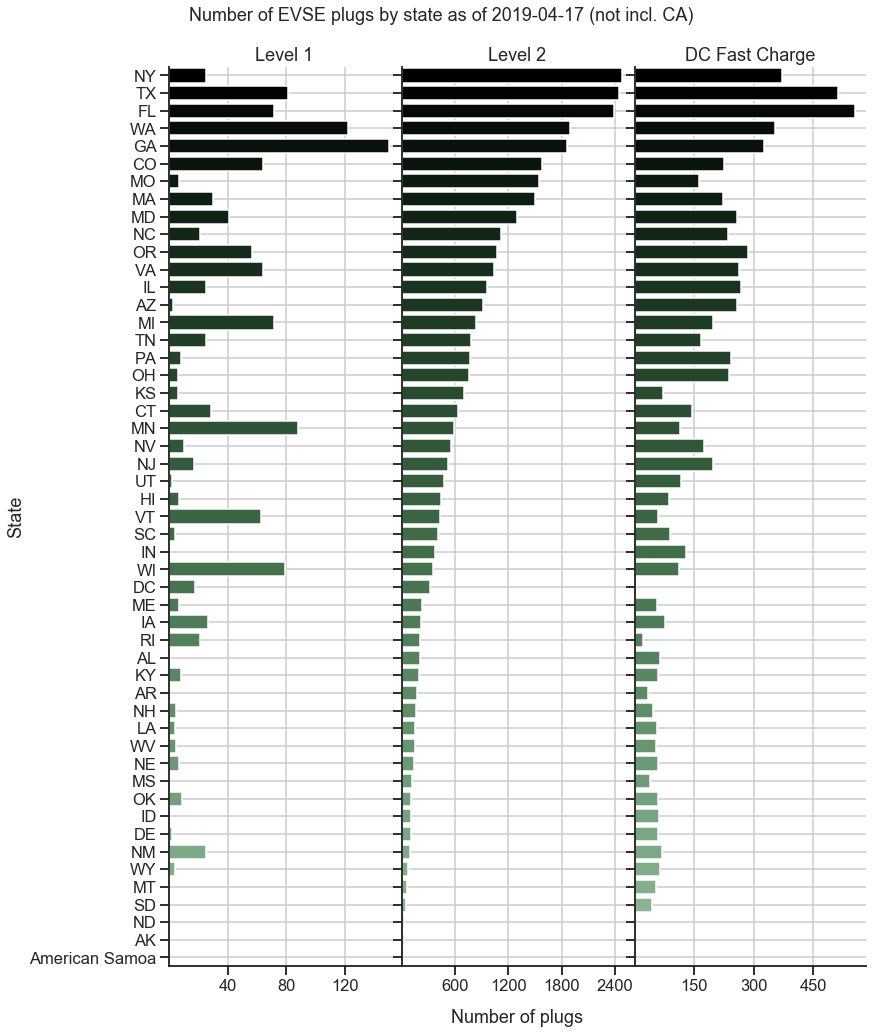

C:\Users\ebarnard\VSE Corporation\OneDrive - VSE Corporation\Research\General Research\Misc Transportation\EV News Webscraper\GitHub\Mike's webscraper


In [17]:
graph_bool = False
if search_date.weekday() == scraper_info['AFV']['day']:
    try:
        # Go into EVSE directory.  This directory should be in the same directory as News_scraper.ipynb. This directory must contain EVSE Market Analysis.ipynb
        %cd EVSE 
        cwd = os.getcwd()
        print(cwd)
        #!jupyter "EVSE Market Analysis.ipynb" --to script
        %run "EVSE Market Analysis.ipynb"
        # Get CA_shares from all_CA_shares.csv
        CA_shares_data = pd.read_csv(cwd + '\\' + 'all_CA_shares.csv', ';')[['date', 'text']]
        CA_shares_data.set_index('date', inplace = True)
        
        EVSE_file_dict = {
            'EVSE_bar_chart' : cwd + '\\'+ f'EVSE_bar_chart_{search_date_str}.png', # Get bar chart
            'CA_shares' : CA_shares_data.loc[search_date_str]['text'], # Get CA shares from today
            
        }
        # Open deltstations.xlsx file for copying and pasting delt stations table into AFV news
        os.startfile(cwd + '\\' + f'{search_date_str}_deltstation.xlsx')
        graph_bool = True # Means all the necessary files are in the directory. If false, graphs will not be added to the docx
    except:
        print('There is a problem with one of the files.  The possibilities are:')
        print('\t1. ' + "alt_fuel_stations ({}).csv".format((dt.datetime.today() - dt.timedelta(days=14)).strftime("%B %d %Y")) + 'is not in the EVSE folder.')
        print('\t2. ' + "alt_fuel_stations ({}).csv".format((dt.datetime.today() - dt.timedelta(days=7)).strftime("%B %d %Y")) + 'is not in the EVSE folder.')
        print('\t3. all_CA_shares.csv is not in the EVSE folder.')
        print('\t4. ' + search_date_str + ' is not in the all_CA_shares.csv file.')
    %cd ..

## Create Word file from the news update spreadsheets
Automatically does CAV on Mondays, AFV on Wednesdays, and 21CTP on Fridays. 

In [18]:
cwd = os.getcwd()
for scraper in todays_scrapers:
    if scraper_info[scraper]['gen_docx']:
        print(scraper)
        docx_filename = cwd + '/'+ gen_docx(scraper, graph_bool)
        os.startfile(docx_filename)

AFV


## Update news item tracking and news scraper meta-data databases
Only run when **final** news item spreadsheet is saved in your working directory (i.e., after you have manually added other articles to the already-saved spreadsheet from the cell above)

In [19]:
# This is in case you go to upload this week's news items to the database, and realize you forgot to do last week's. Just replace
# all instances of "search_date_str" in the next cell with "last_week"and run it. Make sure you switch them all back to "search_date_str"..
last_week = str((pd.to_datetime(search_date_str) - dt.timedelta(days=7)).date())

In [20]:
conn = sqlite3.connect('news_updates.db')
if (search_date.weekday() == scraper_info['CAV']['day']) & (~db_update):
    print('CAV')
    pd.read_excel('cav_news_updates/{}_cav_news_download.xls'.format(search_date_str)
                  ).to_sql('CAV', conn, if_exists='append', index=False)
    db_update = True
elif (search_date.weekday() == scraper_info['AFV']['day']) & (~db_update):
    print('AFV')
    pd.read_excel('afv_news_updates/{}_afv_news_download.xls'.format(search_date_str)
                  ).to_sql('AFV', conn, if_exists='append', index=False)
    db_update = True
conn.close()

# This saves the meta-data from all of the scraper runs every Wednesday (print out "scrape_specs_df" to see what the meta-data includes)
if search_date.weekday() == 2:
    conn = sqlite3.connect('news_updates_meta.db')
    scrape_specs_df.drop(['Time spent', 'Time per relevant article'], axis=1).to_sql(
        'news_updates_meta', conn, if_exists='append', index=False)
    conn.close()
    print('Uploaded metadata! So many datas!')
    
# Need to add 21CTP, evtol, and hyperloop metadata?

AFV
Uploaded metadata! So many datas!


C:\Users\ebarnard\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:2130: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


## Halt run all

In [21]:
assert False #Will generate an error and stop notebook execution

AssertionError: 

# For scraper testing (no need to run)

## Testing a single website

For testing a single scraper - only needed when adding new sites (don't want to run all of them over and over...)

In [ ]:
#driver = webdriver.Chrome()

scrape_specs = {}
scraypahs = {}
temp_start_time = time.time()

site = 'Cummins'
scraypahs[site] = scraypah(scraper_dict[site])
if scraper_dict[site]['css_bool'] == True:
    scraypahs[site].css_scrape_em()
else:
    scraypahs[site].get_urls()
    scraypahs[site].scrape_em()
scrape_specs = print_results(scraypahs[site].source, scraypahs[site].scraped_count, scraypahs[site].skip_count,
                             scraypahs[site].too_old, scraypahs[site].relevant_df, round(
                                 time.time()-temp_start_time, 2),
                             scrape_specs)

# For scraper development (no need to run)

In [ ]:
 'GreenCarCongress': {'url': ['http://www.greencarcongress.com/', 'http://www.greencarcongress.com/page/2/'],
                                     'source': 'GreenCarCongress',
                                     'css_bool': False,
                                     'strain_tag': 'article',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'post entry',
                                     'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('article', attrs={'class': 'post entry'})]",
                                     'date_loc': "article.find('span', attrs={'class':'entry-date'}).a.text",
                                     'date_format': None,
                                     'sum_loc': "article.find_all('p')",
                                     'title_loc': "article.h2.a.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'rating': 1},

In [ ]:
'GreenCarCongress': {'url': [f'http://www.greencarcongress.com/page/{page_no}/' for page_no in range(1,8)],
                                     'source': 'GreenCarCongress',
                                     'css_bool': False,
                                     'strain_tag': 'article',
                                     'strain_attr_name': 'class',
                                     'strain_attr_value': 'post entry',
                                     'url_list_query': "[item.a['href'] for item in self.base_soup.find_all('article', attrs={'class': 'post entry'})]",
                                     'date_loc': "article.find('span', attrs={'class':'entry-date'}).a.text",
                                     'date_format': None,
                                     'sum_loc': "article.find_all('p')",
                                     'title_loc': "article.h2.a.text",
                                     'strain_bool': True,
                                     'journal_bool': False,
                                     'rating': 1},

In [ ]:
'Quartz': {'url': 'https://qz.com/search/self-driving',
                           'source': 'Quartz',
                           'css_bool': False,
                           'url_list_query': "['https://qz.com' + a['href'] for a in self.base_soup.find_all('a', class_='_5ff1a')]",
                           'date_loc': "article.time.text",
                           'date_format': None,
                           'sum_loc': "article.find_all('p')",
                           'title_loc': "article.h1.text",
                           'strain_bool': False,
                           'journal_bool': False,
                           'rating': 2},

## Set url, date, summary, and title locations

In [ ]:
base_urls = ['https://qz.com/search/self-driving']
url_loc = "[header.a['href'] for header in soup.find_all('h2') if header.a!=None]"
date_loc = "article.time.text"
sum_loc = "article.find_all('p')"
title_loc = "article.h1.text"

## Test a site using selenium

In [ ]:
driver = webdriver.Chrome()
for base_url in base_urls:
    driver.get(base_url)
    urls = eval(url_loc)
    for url in urls:
        driver.get(url)
        article = BeautifulSoup(driver.page_source)
        title = eval(title_loc)
        date = eval(date_loc)
        summary = eval(sum_loc)
        print(title, '\n', date, '\n', summary, '\n\n')

## Test a site using only Beautiful Soup

In [ ]:
for base_url in base_urls:
    soup = grab_homepage(base_url)
    urls = eval(url_loc)
    for url in urls: 
        article = grab_homepage(url)
        title = eval(title_loc)
        date = eval(date_loc)
        summary = eval(sum_loc)
        print(title, '\n', date, '\n\n')

# Change Log
* 8/29/2018: Added Citylab, Electrek, cleaned code
* 8/7/2018: Added Transport Reviews to academic paper scraper
* 7/30/2018: Fixed GovTech scraper
* 6/29/2018: Changed the whole scraper over to utilize a new class called *scraypah*. 
* 5/12/2018: Added Semiconductor Engineering scraper and academic articles scraper (~3 hours)
* 4/13/2018: Integrated word document production through python
* 3/19/2018: Added OEM/Gov section that quickly checks 17 sites for updates - only prints a notification that it needs to be checked if there are new updates from the past week
* 2/27/2018: Wrote a function *page_scan* to more efficiently create the relevant web page dictionary "profiles"
* 2/27/2018: Added 21CTP trucking news keywords to search for. Integrated functionality into existing web scraper.
* 2/14/2018: Added NGV Global scraper for AFV stuff
* 2/14/2018: Added fuel cells, hybrid, hybrid-electric, 'electric buses', 'electric truck', 'electric trucks', 'electric drive' to the search terms for AFVs...
* 1/31/2018: Added *print_results* function to streamline printed results for each scraper. Added counter to track #articles that were too old. Added meta-data tracking capability (dumps into SQL database every week)
* 1/31/2018: Split EV market analysis and web scraper into two different Notebooks
* 1/26/2018: Added Lexology scraper
* 1/19/2018: Fixed GreenCarCongress scraper (site redesign)
* 1/4/2018: Added Engadget scraper
* 1/4/2018: Added "replace_em" function to streamline removal of meaningless substrings from body text summaries
* 12/29/2017: Added Reuters, MITNews, and ARSTechnica scrapers. Did some streamlining in the EV Sales analysis
* 12/20/2017: Wrote up quick-guide to all the post-Python processing needed for the final News Update doc.
* 12/20/2017: Changed to .xls format. Had to import a different package to do so, but makes mail merge work better
* 12/13/2017: Fixed Trucks.com scraper - was pulling out the wrong date for each article (pulled a date from the sidebar...)
* 12/8/2017: Edited Trucks.com search so that it doesn't pick up paragraph tags that are actually image captions (added condition that "class = None")
* 12/8/2017: Added a bunch of comments, specifically in the first code segment ("IEEE Spectrum") for explanatory purposes
* 1/8/2019: Added Green Car Reports, DOE, Business Wire, and The Fuse.
* 1/10/2019: Uploaded ipynb to Energetics' GitHub (EICode).  Log entries can now be found via GitHub.